In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


MODEL WITH GLOBAL CHARACTERISTICS ANALYSIS

In [ ]:
!pip install scikit-learn
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam # Add this line to import the Adam
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_absolute_error # Import the mean_absolute_error function
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


%load_ext tensorboard

import os
log_dir = os.path.join("logs") # Puedes cambiar "logs" por el nombre que quieras
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Cargar los datos (suponiendo que están en un archivo CSV)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM.csv')

#ARREGLO PARA CALC_IMC NULL
data['CALC_IMC'] = data.groupby('ID')['CALC_IMC'].transform(lambda x: round(x.fillna(x.mean()), 0))
#eliminar filas con datos nulos en IMC
data = data.dropna(subset=['CALC_IMC'])

# Contar registros por ID, ignorando los NaN
#conteo_registros_por_persona = data.groupby('ID')['ID'].count()

# Personas con exactamente 4 registros (sin considerar NaN)
#personas_con_4_registros = conteo_registros_por_persona[conteo_registros_por_persona == 4]
#print(personas_con_4_registros)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv')

# Normalize numerical variables
columns_to_scale = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION','CIGARRETTES','DRINK','CALC_IMC', 'AGE']
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
#data[columns_to_scale] = scaled_data
data.loc[:, columns_to_scale] = scaled_data

# Convert categorical variables to one-hot encoding
# Crear un objeto OneHotEncoder
columns_to_transform = ['SEX','ALONE','PHYSICAL_ACTIVITY']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[columns_to_transform])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_transform))
data = pd.concat([data, encoded_df], axis=1)

#data = data.drop(columns=['SEX','ALONE','PHYSICAL_ACTIVITY'])

# Agrupar por ID y ordenar por 'Evaluación'
#data_grouped = data.sort_values('evaluacion').groupby('ID')

#data = data.drop(columns=['ID','año','evaluación'])

#data.head()
#print(data.columns)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_ENCODED.csv', index=False)

# Definimos las columnas de las variables a predecir (target)
target_cols = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION']

# Prepare sequences and targets
def create_dataset(data, look_back=3):
  sequences = []
  targets = []
  locomotions = []
  sensories = []
  vitalities = []
  psichologicals = []
  cognitions = []
  auxiliares = []
  for person_id in data['ID'].unique():
    person_data = data[data['ID'] == person_id].sort_values('evaluacion')

     # Get the indices of the relevant columns
    relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY','PSICHOLOGICAL', 'COGNITION',
                        'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                        'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD','PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                        'CIGARRETTES','DRINK', 'CALC_IMC']
    auxiliar_columns = ['AGE','SEX_FEMALE', 'SEX_MALE']
     # Select the relevant columns first
    person_data_values = person_data[relevant_columns].values
    person_data_auxiliar = person_data[auxiliar_columns].values

    # Create sequences and targets
    if len(person_data_values) < look_back + 1:
        continue
    sequence = person_data_values[:look_back, :]
    target = person_data_values[look_back, data.columns.get_indexer(target_cols)]
    locomotion = person_data_values[look_back, 0]
    sensory = person_data_values[look_back, 1]
    vitality = person_data_values[look_back, 2]
    psichological = person_data_values[look_back, 3]
    cognition = person_data_values[look_back, 4]
    auxiliar = person_data_auxiliar[look_back, :]
    sequences.append(sequence)
    targets.append(target)
    locomotions.append(locomotion)
    sensories.append(sensory)
    vitalities.append(vitality)
    psichologicals.append(psichological)
    cognitions.append(cognition)
    auxiliares.append(auxiliar)
  return np.array(sequences), np.array(targets), np.array(locomotions), np.array(sensories), np.array(vitalities), np.array(psichologicals), np.array(cognitions), np.array(auxiliares)

# Create sequences and targets
look_back = 3
sequences, targets, locomotions, sensories, vitalities, psichologicals, cognitions, auxiliares = create_dataset(data, look_back)

pd.DataFrame(sequences[0]).head()
sequences.shape
sequences.shape[2]

sequences.shape[2]
#pd.DataFrame(targets[0]).head()

auxiliares.shape
auxiliares.shape[1]

targets.shape

# TRAINNING AND TEST

# Assuming 'sequences' and 'auxiliares' are your input features,
# and 'locomotions', 'sensories', etc. are your targets
# Split into 80% training and 20% testing
(
    sequences_train,
    sequences_test,
    auxiliares_train,
    auxiliares_test,
    locomotions_train,
    locomotions_test,
    sensories_train,
    sensories_test,
    vitalities_train,
    vitalities_test,
    psichologicals_train,
    psichologicals_test,
    cognitions_train,
    cognitions_test,
) = train_test_split(
    sequences,
    auxiliares,
    locomotions,
    sensories,
    vitalities,
    psichologicals,
    cognitions,
    test_size=0.2,
    random_state=42,  # Optional: for reproducibility
)


# Define input shapes
sequential_input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust num_sequential_features
auxiliary_input_shape = (auxiliares.shape[1],)  # Adjust num_auxiliary_features

# Create the model
def create_model_rf():
    model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
    return model

model = create_model_rf()

# Reshape and combine data for Random Forest
X_train = np.concatenate([sequences_train.reshape(sequences_train.shape[0], -1), auxiliares_train], axis=1)
X_test = np.concatenate([sequences_test.reshape(sequences_test.shape[0], -1), auxiliares_test], axis=1)
y_train = np.concatenate([locomotions_train[:, np.newaxis], sensories_train[:, np.newaxis],
                         vitalities_train[:, np.newaxis], psichologicals_train[:, np.newaxis],
                         cognitions_train[:, np.newaxis]], axis=1)
y_test = np.concatenate([locomotions_test[:, np.newaxis], sensories_test[:, np.newaxis],
                        vitalities_test[:, np.newaxis], psichologicals_test[:, np.newaxis],
                        cognitions_test[:, np.newaxis]], axis=1)

# Train the Random Forest model
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)


# Función para calcular MAE con intervalo de confianza usando Bootstrap (CÓDIGO NUEVO)
def calcular_intervalos_confianza(model, X_test, y_test, num_bootstrap_samples=1000):
    bootstrap_maes = []
    for _ in range(num_bootstrap_samples):
        X_test_resampled, y_test_resampled = resample(X_test, y_test, replace=True)
        predictions = model.predict(X_test_resampled)

     # Calculate MAE for each target and store them
        maes_for_this_bootstrap = [mean_absolute_error(y_test_resampled[:, i], predictions[:, i])
                                 for i in range(y_test.shape[1])]
        bootstrap_maes.append(maes_for_this_bootstrap)

    bootstrap_maes = np.array(bootstrap_maes)
    lower_percentile = 2.5  # For 95% CI
    upper_percentile = 97.5  # For 95% CI

    # Calculate CI directly for MAE values
    confidence_intervals = []
    for i in range(y_test.shape[1]):
        lower_bound = np.percentile(bootstrap_maes[:, i], lower_percentile)
        upper_bound = np.percentile(bootstrap_maes[:, i], upper_percentile)
        confidence_intervals.append((lower_bound, upper_bound))

    return confidence_intervals

confidence_intervals = calcular_intervalos_confianza(model, X_test, y_test)


# Define target names here
target_names = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION']

# --- Evaluation before Confidence Intervals ---
predictions = model.predict(X_test)  # Make predictions on the original test data

# --- Calculate Total Loss ---
total_loss = 0
for i in range(len(target_names)):
    loss_for_target = mean_absolute_error(y_test[:, i], predictions[:, i])
    total_loss += loss_for_target

total_loss /= len(target_names)  # Average the losses

print(f"Total Loss: {total_loss:.4f}")


# Print evaluation metrics (e.g., MAE)
for i in range(len(target_names)):
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    print(f"MAE for {target_names[i]}: {mae:.4f}")



# Calculate confidence intervals
confidence_intervals = calcular_intervalos_confianza(model, X_test, y_test)

# Make predictions using the trained SVM model
predictions = model.predict(X_test)

# Evaluate performance (including confidence intervals)
for i in range(len(target_names)):
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    lower_bound, upper_bound = confidence_intervals[i]
    print(f"MAE for {target_names[i]}: {mae:.4f} (95% CI: [{lower_bound:.4f}, {upper_bound:.4f}])")

# Obtén la importancia de las características
# Get feature names for sequences data
# Get feature names for sequences data
sequence_features = [f'sequence_{i}_{j}' for i in range(sequences_train.shape[1])
                     for j in range(sequences_train.shape[2])]

# --- Mapping to Original Names ---
relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION',
                       'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                       'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD',
                       'PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                       'CIGARRETTES', 'DRINK', 'CALC_IMC']
original_sequence_feature_names = []
for feature_name in sequence_features:
    parts = feature_name.split('_')  # Split the name into parts
    time_step = int(parts[1])  # Get the time step
    feature_index = int(parts[2])  # Get the feature index

    original_name = relevant_columns[feature_index]  # Get the original name from relevant_columns
    original_sequence_feature_names.append(f'{original_name}_t-{time_step}')  # Format the name (e.g., LOCOMOTION_t-0)


# Get feature names for auxiliares data
auxiliary_features = ['AGE', 'SEX_FEMALE', 'SEX_MALE']  # Replace with actual names if different

# Combine feature names
features = original_sequence_feature_names + auxiliary_features


importances = model.feature_importances_
# Crea un DataFrame para visualizar la importancia de las características
feature_importances = pd.DataFrame({'feature': features, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Crea un gráfico de barras para visualizar la importancia de las características
plt.figure(figsize=(10, 6))
plt.bar(feature_importances['feature'], feature_importances['importance'])
plt.xticks(rotation=90)
plt.xlabel('Característica')
plt.ylabel('Importancia')
plt.title('Importancia de las características en el modelo Random Forest')
plt.tight_layout()
plt.show()


ValueError: Name tf.RaggedTensorSpec has already been registered for class tensorflow.python.ops.ragged.ragged_tensor.RaggedTensorSpec.

MODEL WITH ANALYSIS OF CHARACTERISTICS BY DOMAIN

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<ipython-input-8-670c504994cb>:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.81818182 0.90909091 ... 0.72727273 0.54545455 0.81818182]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data
<ipython-input-8-670c504994cb>:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.61428571 0.65714286 0.71428571 ... 0.32857143 0.38571429 0.44285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data


Total Loss: 0.1066
MAE for LOCOMOTION: 0.1398
MAE for SENSORY: 0.0984
MAE for VITALITY: 0.1143
MAE for PSICHOLOGICAL: 0.0997
MAE for COGNITION: 0.0810
MAE for LOCOMOTION: 0.1398 (95% CI: [0.1272, 0.1528])
MAE for SENSORY: 0.0984 (95% CI: [0.0906, 0.1066])
MAE for VITALITY: 0.1143 (95% CI: [0.1065, 0.1220])
MAE for PSICHOLOGICAL: 0.0997 (95% CI: [0.0891, 0.1111])
MAE for COGNITION: 0.0810 (95% CI: [0.0749, 0.0882])


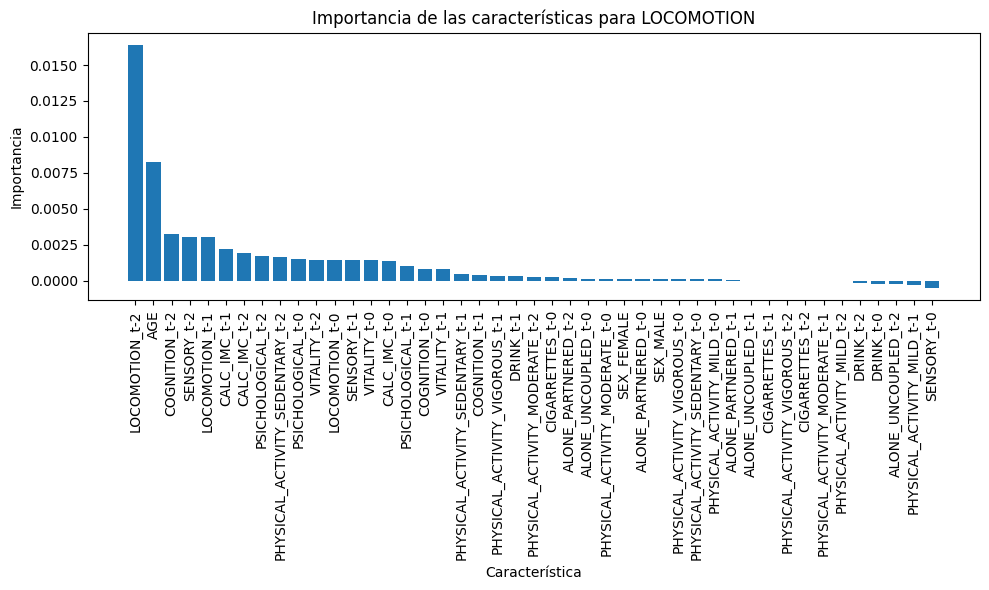

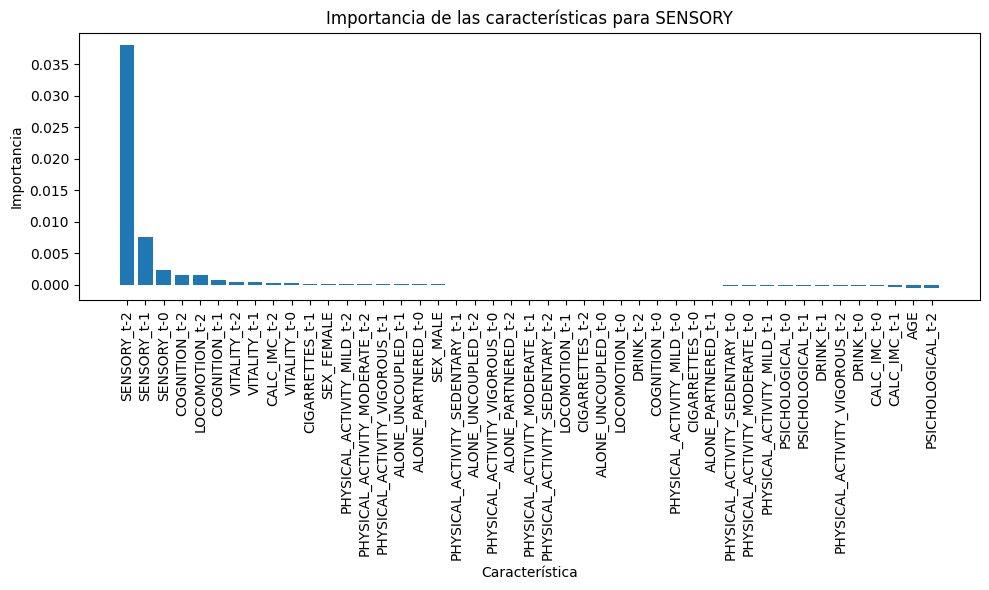

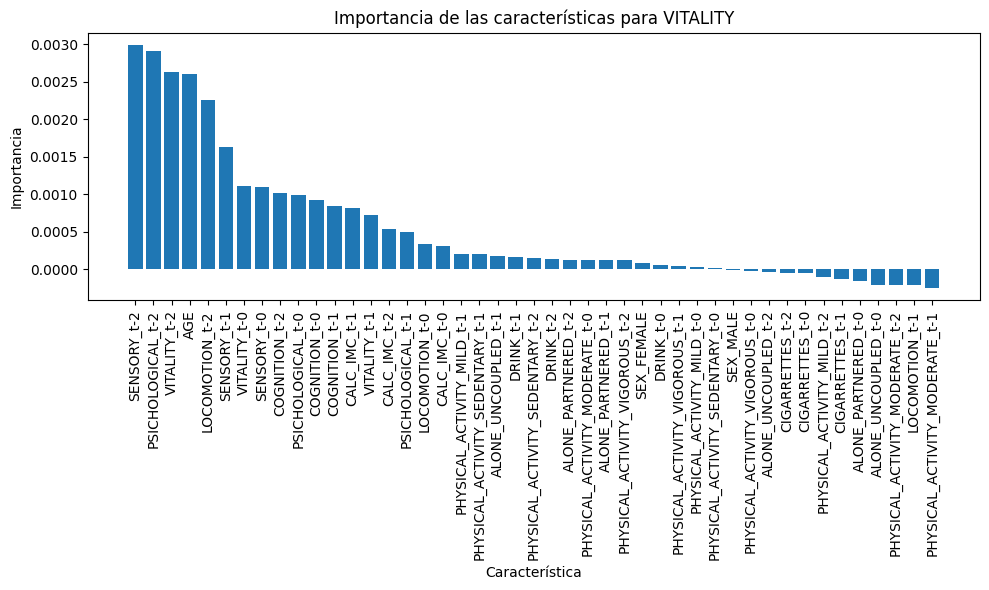

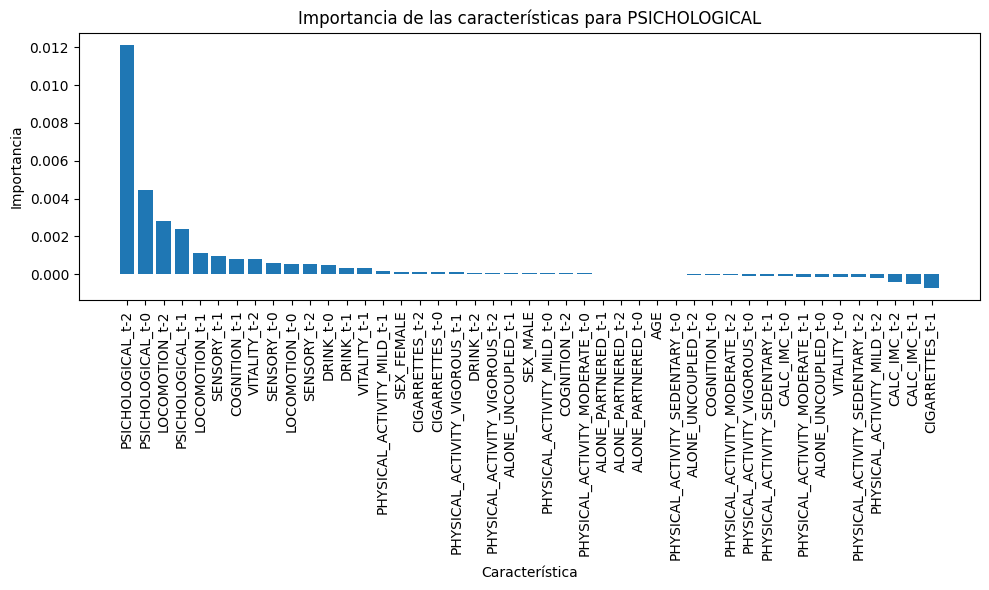

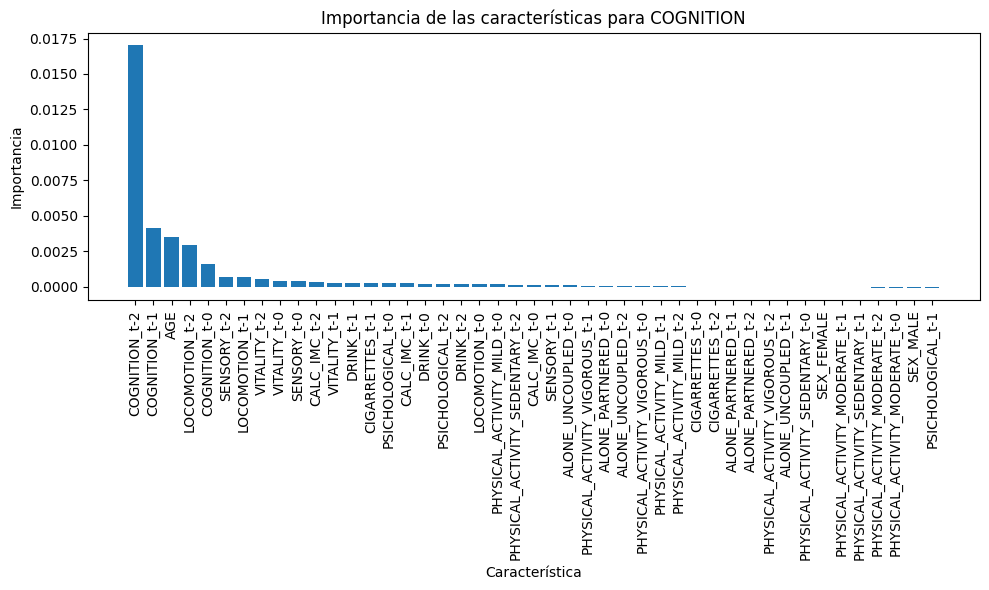

In [ ]:
!pip install scikit-learn
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam # Add this line to import the Adam
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import  make_scorer, mean_absolute_error # Import the mean_absolute_error function
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


%load_ext tensorboard

import os
log_dir = os.path.join("logs") # Puedes cambiar "logs" por el nombre que quieras
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Cargar los datos (suponiendo que están en un archivo CSV)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM.csv')

#ARREGLO PARA CALC_IMC NULL
data['CALC_IMC'] = data.groupby('ID')['CALC_IMC'].transform(lambda x: round(x.fillna(x.mean()), 0))
#eliminar filas con datos nulos en IMC
data = data.dropna(subset=['CALC_IMC'])

# Contar registros por ID, ignorando los NaN
#conteo_registros_por_persona = data.groupby('ID')['ID'].count()

# Personas con exactamente 4 registros (sin considerar NaN)
#personas_con_4_registros = conteo_registros_por_persona[conteo_registros_por_persona == 4]
#print(personas_con_4_registros)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv')

# Normalize numerical variables
columns_to_scale = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION','CIGARRETTES','DRINK','CALC_IMC', 'AGE']
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
#data[columns_to_scale] = scaled_data
data.loc[:, columns_to_scale] = scaled_data

# Convert categorical variables to one-hot encoding
# Crear un objeto OneHotEncoder
columns_to_transform = ['SEX','ALONE','PHYSICAL_ACTIVITY']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[columns_to_transform])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_transform))
data = pd.concat([data, encoded_df], axis=1)

#data = data.drop(columns=['SEX','ALONE','PHYSICAL_ACTIVITY'])

# Agrupar por ID y ordenar por 'Evaluación'
#data_grouped = data.sort_values('evaluacion').groupby('ID')

#data = data.drop(columns=['ID','año','evaluación'])

#data.head()
#print(data.columns)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_ENCODED.csv', index=False)

# Definimos las columnas de las variables a predecir (target)
target_cols = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION']

# Prepare sequences and targets
def create_dataset(data, look_back=3):
  sequences = []
  targets = []
  locomotions = []
  sensories = []
  vitalities = []
  psichologicals = []
  cognitions = []
  auxiliares = []
  for person_id in data['ID'].unique():
    person_data = data[data['ID'] == person_id].sort_values('evaluacion')

     # Get the indices of the relevant columns
    relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY','PSICHOLOGICAL', 'COGNITION',
                        'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                        'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD','PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                        'CIGARRETTES','DRINK', 'CALC_IMC']
    auxiliar_columns = ['AGE','SEX_FEMALE', 'SEX_MALE']
     # Select the relevant columns first
    person_data_values = person_data[relevant_columns].values
    person_data_auxiliar = person_data[auxiliar_columns].values

    # Create sequences and targets
    if len(person_data_values) < look_back + 1:
        continue
    sequence = person_data_values[:look_back, :]
    target = person_data_values[look_back, data.columns.get_indexer(target_cols)]
    locomotion = person_data_values[look_back, 0]
    sensory = person_data_values[look_back, 1]
    vitality = person_data_values[look_back, 2]
    psichological = person_data_values[look_back, 3]
    cognition = person_data_values[look_back, 4]
    auxiliar = person_data_auxiliar[look_back, :]
    sequences.append(sequence)
    targets.append(target)
    locomotions.append(locomotion)
    sensories.append(sensory)
    vitalities.append(vitality)
    psichologicals.append(psichological)
    cognitions.append(cognition)
    auxiliares.append(auxiliar)
  return np.array(sequences), np.array(targets), np.array(locomotions), np.array(sensories), np.array(vitalities), np.array(psichologicals), np.array(cognitions), np.array(auxiliares)

# Create sequences and targets
look_back = 3
sequences, targets, locomotions, sensories, vitalities, psichologicals, cognitions, auxiliares = create_dataset(data, look_back)

pd.DataFrame(sequences[0]).head()
sequences.shape
sequences.shape[2]

sequences.shape[2]
#pd.DataFrame(targets[0]).head()

auxiliares.shape
auxiliares.shape[1]

targets.shape

# TRAINNING AND TEST

# Assuming 'sequences' and 'auxiliares' are your input features,
# and 'locomotions', 'sensories', etc. are your targets
# Split into 80% training and 20% testing
(
    sequences_train,
    sequences_test,
    auxiliares_train,
    auxiliares_test,
    locomotions_train,
    locomotions_test,
    sensories_train,
    sensories_test,
    vitalities_train,
    vitalities_test,
    psichologicals_train,
    psichologicals_test,
    cognitions_train,
    cognitions_test,
) = train_test_split(
    sequences,
    auxiliares,
    locomotions,
    sensories,
    vitalities,
    psichologicals,
    cognitions,
    test_size=0.2,
    random_state=42,  # Optional: for reproducibility
)


# Define input shapes
sequential_input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust num_sequential_features
auxiliary_input_shape = (auxiliares.shape[1],)  # Adjust num_auxiliary_features

# Create the model
def create_model_rf():
    model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
    return model

model = create_model_rf()

# Reshape and combine data for Random Forest
X_train = np.concatenate([sequences_train.reshape(sequences_train.shape[0], -1), auxiliares_train], axis=1)
X_test = np.concatenate([sequences_test.reshape(sequences_test.shape[0], -1), auxiliares_test], axis=1)
y_train = np.concatenate([locomotions_train[:, np.newaxis], sensories_train[:, np.newaxis],
                         vitalities_train[:, np.newaxis], psichologicals_train[:, np.newaxis],
                         cognitions_train[:, np.newaxis]], axis=1)
y_test = np.concatenate([locomotions_test[:, np.newaxis], sensories_test[:, np.newaxis],
                        vitalities_test[:, np.newaxis], psichologicals_test[:, np.newaxis],
                        cognitions_test[:, np.newaxis]], axis=1)

# Train the Random Forest model
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)


# Función para calcular MAE con intervalo de confianza usando Bootstrap (CÓDIGO NUEVO)
def calcular_intervalos_confianza(model, X_test, y_test, num_bootstrap_samples=1000):
    bootstrap_maes = []
    for _ in range(num_bootstrap_samples):
        X_test_resampled, y_test_resampled = resample(X_test, y_test, replace=True)
        predictions = model.predict(X_test_resampled)

     # Calculate MAE for each target and store them
        maes_for_this_bootstrap = [mean_absolute_error(y_test_resampled[:, i], predictions[:, i])
                                 for i in range(y_test.shape[1])]
        bootstrap_maes.append(maes_for_this_bootstrap)

    bootstrap_maes = np.array(bootstrap_maes)
    lower_percentile = 2.5  # For 95% CI
    upper_percentile = 97.5  # For 95% CI

    # Calculate CI directly for MAE values
    confidence_intervals = []
    for i in range(y_test.shape[1]):
        lower_bound = np.percentile(bootstrap_maes[:, i], lower_percentile)
        upper_bound = np.percentile(bootstrap_maes[:, i], upper_percentile)
        confidence_intervals.append((lower_bound, upper_bound))

    return confidence_intervals

confidence_intervals = calcular_intervalos_confianza(model, X_test, y_test)


# Define target names here
target_names = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION']

# --- Evaluation before Confidence Intervals ---
predictions = model.predict(X_test)  # Make predictions on the original test data

# --- Calculate Total Loss ---
total_loss = 0
for i in range(len(target_names)):
    loss_for_target = mean_absolute_error(y_test[:, i], predictions[:, i])
    total_loss += loss_for_target

total_loss /= len(target_names)  # Average the losses

print(f"Total Loss: {total_loss:.4f}")


# Print evaluation metrics (e.g., MAE)
for i in range(len(target_names)):
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    print(f"MAE for {target_names[i]}: {mae:.4f}")



# Calculate confidence intervals
confidence_intervals = calcular_intervalos_confianza(model, X_test, y_test)

# Make predictions using the trained SVM model
predictions = model.predict(X_test)

# Evaluate performance (including confidence intervals)
for i in range(len(target_names)):
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    lower_bound, upper_bound = confidence_intervals[i]
    print(f"MAE for {target_names[i]}: {mae:.4f} (95% CI: [{lower_bound:.4f}, {upper_bound:.4f}])")

# Obtén la importancia de las características
# Get feature names for sequences data
# Get feature names for sequences data
sequence_features = [f'sequence_{i}_{j}' for i in range(sequences_train.shape[1])
                     for j in range(sequences_train.shape[2])]

# --- Mapping to Original Names ---
relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION',
                       'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                       'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD',
                       'PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                       'CIGARRETTES', 'DRINK', 'CALC_IMC']
original_sequence_feature_names = []
for feature_name in sequence_features:
    parts = feature_name.split('_')  # Split the name into parts
    time_step = int(parts[1])  # Get the time step
    feature_index = int(parts[2])  # Get the feature index

    original_name = relevant_columns[feature_index]  # Get the original name from relevant_columns
    original_sequence_feature_names.append(f'{original_name}_t-{time_step}')  # Format the name (e.g., LOCOMOTION_t-0)


# Get feature names for auxiliares data
auxiliary_features = ['AGE', 'SEX_FEMALE', 'SEX_MALE']  # Replace with actual names if different

# Combine feature names
features = original_sequence_feature_names + auxiliary_features


# --- Feature Importance Visualization with Original Names ---
from sklearn.inspection import permutation_importance

target_names = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION']

# Create a wrapper function for single-output prediction
def single_output_model(model, target_index):
    def predict(X):
        return model.predict(X)[:, target_index]  # Return prediction for specific target

    # Add a dummy fit method
    def fit(X, y=None):
        return self

    # Create a class with predict and fit methods
    class SingleOutputModel:
        def __init__(self, predict_func, fit_func):
            self.predict = predict_func
            self.fit = fit_func

    return SingleOutputModel(predict, fit)

for i, target_name in enumerate(target_names):
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Create a single-output model wrapper
    single_output_predictor = single_output_model(model, i)

    result = permutation_importance(
        single_output_predictor,  # Use the wrapper for single output
        X_test,
        y_test[:, i],  # Evaluate for a single target
        n_repeats=10,
        random_state=42,
        scoring=scorer  # Use the custom scorer
    )

    # Organize and plot the results
    importance = result.importances_mean
    features = original_sequence_feature_names + auxiliary_features  # Assuming you have these defined

    # Create a DataFrame for this target's importances
    feature_importances_target = pd.DataFrame({'feature': features, 'importance': importance})
    feature_importances_target = feature_importances_target.sort_values('importance', ascending=False)

    # Plot feature importance for current target
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importances_target['feature'], feature_importances_target['importance'])
    plt.xticks(rotation=90)
    plt.xlabel('Característica')
    plt.ylabel('Importancia')
    plt.title(f'Importancia de las características para {target_name}')
    plt.tight_layout()
    plt.show()

RF MODEL WITHOUT SEQUENCES

<ipython-input-2-910ed3481dc7>:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.81818182 0.90909091 ... 0.72727273 0.54545455 0.81818182]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data
<ipython-input-2-910ed3481dc7>:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.61428571 0.65714286 0.71428571 ... 0.32857143 0.38571429 0.44285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data


Total Loss: 0.0200
MAE for LOCOMOTION: 0.0205
MAE for SENSORY: 0.0171
MAE for VITALITY: 0.0212
MAE for PSICHOLOGICAL: 0.0209
MAE for COGNITION: 0.0201
MAE for LOCOMOTION: 0.0205 (95% CI: [0.0177, 0.0235])
MAE for SENSORY: 0.0171 (95% CI: [0.0143, 0.0199])
MAE for VITALITY: 0.0212 (95% CI: [0.0184, 0.0242])
MAE for PSICHOLOGICAL: 0.0209 (95% CI: [0.0184, 0.0236])
MAE for COGNITION: 0.0201 (95% CI: [0.0178, 0.0227])


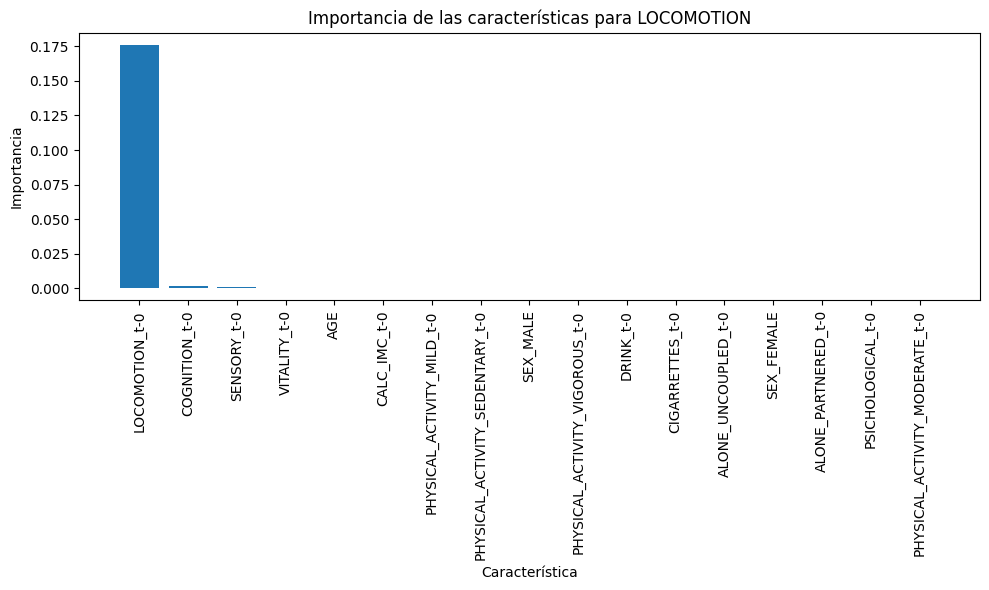

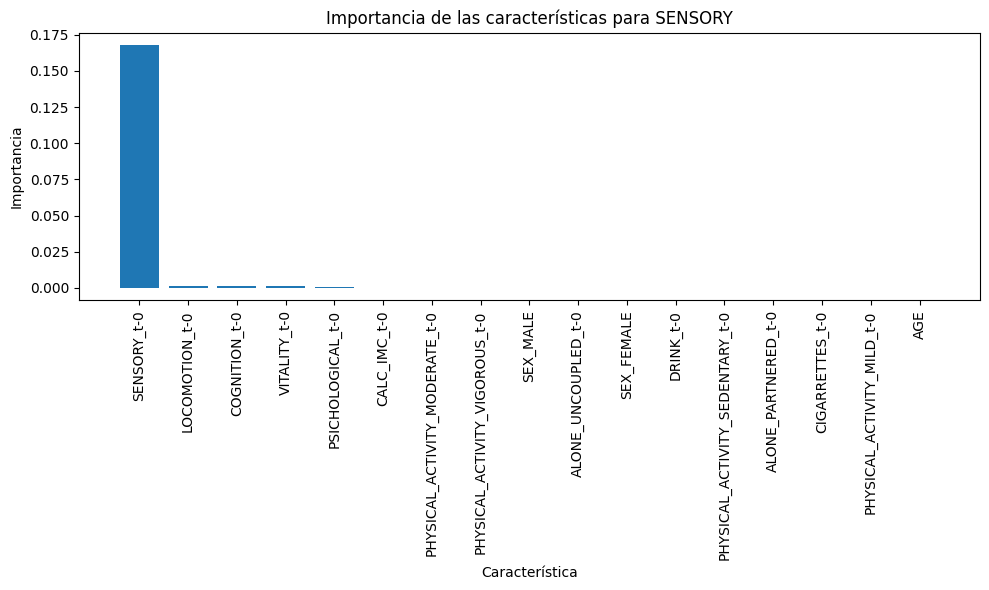

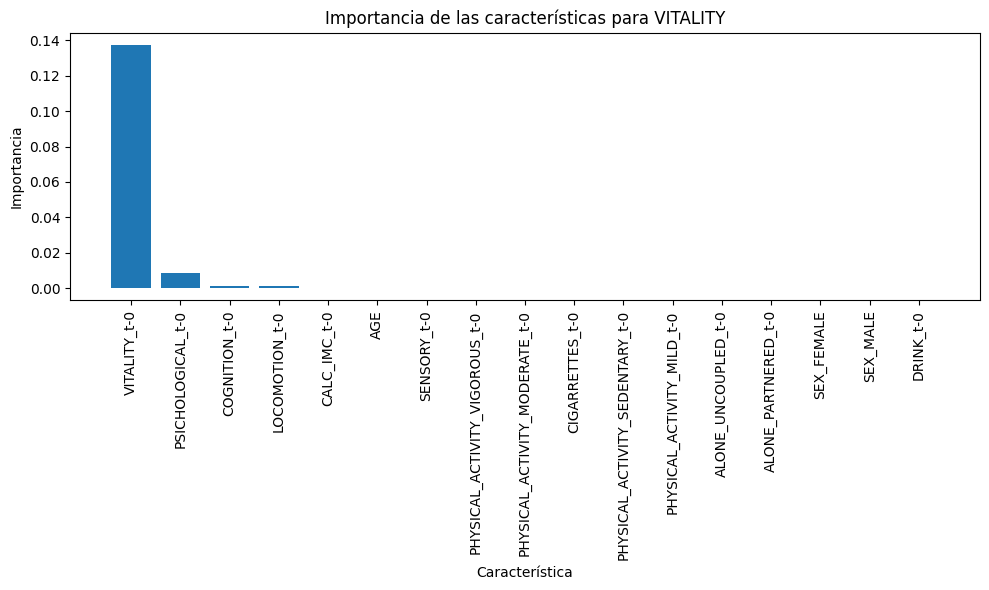

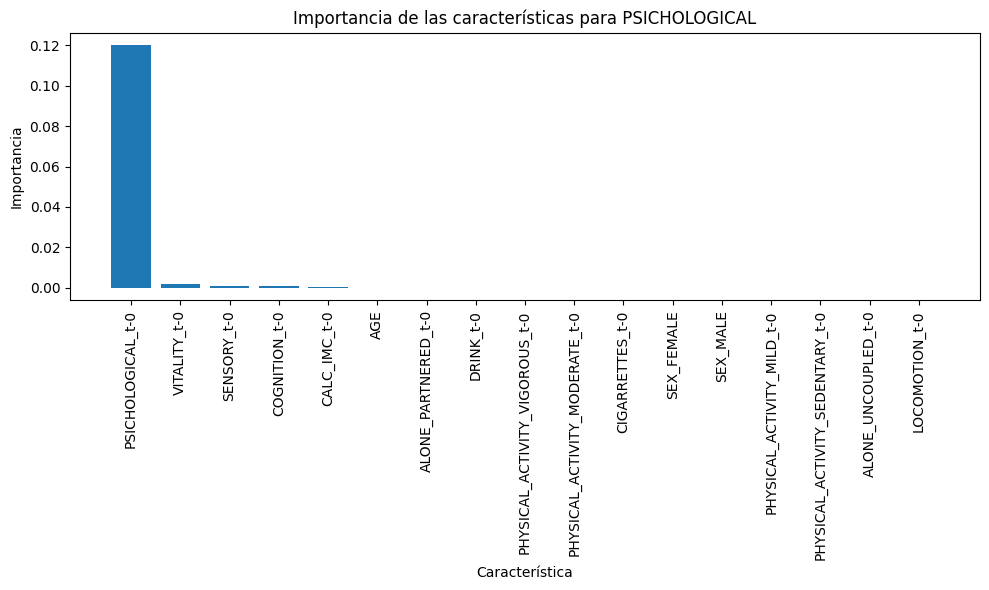

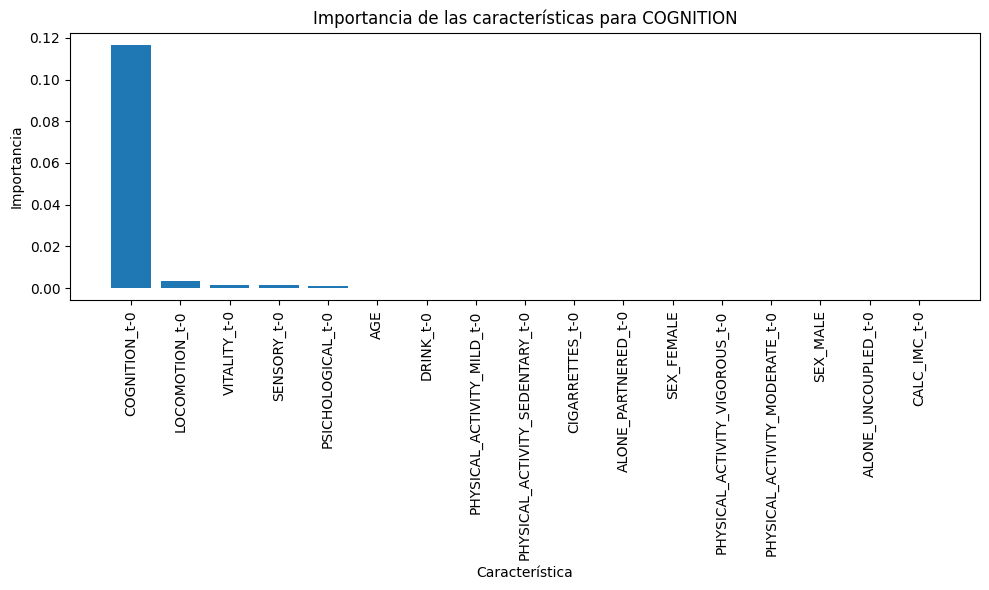

In [ ]:
!pip install scikit-learn
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam # Add this line to import the Adam
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import  make_scorer, mean_absolute_error # Import the mean_absolute_error function
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


%load_ext tensorboard

import os
log_dir = os.path.join("logs") # Puedes cambiar "logs" por el nombre que quieras
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Cargar los datos (suponiendo que están en un archivo CSV)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM.csv')

#ARREGLO PARA CALC_IMC NULL
data['CALC_IMC'] = data.groupby('ID')['CALC_IMC'].transform(lambda x: round(x.fillna(x.mean()), 0))
#eliminar filas con datos nulos en IMC
data = data.dropna(subset=['CALC_IMC'])

# Contar registros por ID, ignorando los NaN
#conteo_registros_por_persona = data.groupby('ID')['ID'].count()

# Personas con exactamente 4 registros (sin considerar NaN)
#personas_con_4_registros = conteo_registros_por_persona[conteo_registros_por_persona == 4]
#print(personas_con_4_registros)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv')

# Normalize numerical variables
columns_to_scale = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION','CIGARRETTES','DRINK','CALC_IMC', 'AGE']
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
#data[columns_to_scale] = scaled_data
data.loc[:, columns_to_scale] = scaled_data

# Convert categorical variables to one-hot encoding
# Crear un objeto OneHotEncoder
columns_to_transform = ['SEX','ALONE','PHYSICAL_ACTIVITY']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[columns_to_transform])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_transform))
data = pd.concat([data, encoded_df], axis=1)

#data = data.drop(columns=['SEX','ALONE','PHYSICAL_ACTIVITY'])

# Agrupar por ID y ordenar por 'Evaluación'
#data_grouped = data.sort_values('evaluacion').groupby('ID')

#data = data.drop(columns=['ID','año','evaluación'])

#data.head()
#print(data.columns)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_ENCODED.csv', index=False)

# Definimos las columnas de las variables a predecir (target)
target_cols = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION']

# Prepare sequences and targets
def create_dataset(data, look_back=3):
  sequences = []
  targets = []
  locomotions = []
  sensories = []
  vitalities = []
  psichologicals = []
  cognitions = []
  auxiliares = []
  for person_id in data['ID'].unique():
    person_data = data[data['ID'] == person_id].sort_values('evaluacion')

    # Select only the last row (last evaluation) for each person
    last_evaluation_data = person_data.tail(1)

     # Get the indices of the relevant columns
    relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY','PSICHOLOGICAL', 'COGNITION',
                        'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                        'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD','PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                        'CIGARRETTES','DRINK', 'CALC_IMC']
    auxiliar_columns = ['AGE','SEX_FEMALE', 'SEX_MALE']
     # Select the relevant columns first
    person_data_values = person_data[relevant_columns].values
    person_data_auxiliar = person_data[auxiliar_columns].values

      # Select the relevant columns
    sequence = last_evaluation_data[relevant_columns].values  # sequence now contains only last evaluation data
    target = last_evaluation_data[target_cols].values.flatten() # target is extracted from last evaluation data
    locomotion = target[0]
    sensory = target[1]
    vitality = target[2]
    psichological = target[3]
    cognition = target[4]
    auxiliar = last_evaluation_data[auxiliar_columns].values.flatten()

    sequences.append(sequence)
    targets.append(target)
    locomotions.append(locomotion)
    sensories.append(sensory)
    vitalities.append(vitality)
    psichologicals.append(psichological)
    cognitions.append(cognition)
    auxiliares.append(auxiliar)
  return np.array(sequences), np.array(targets), np.array(locomotions), np.array(sensories), np.array(vitalities), np.array(psichologicals), np.array(cognitions), np.array(auxiliares)

# Create sequences and targets
sequences, targets, locomotions, sensories, vitalities, psichologicals, cognitions, auxiliares = create_dataset(data)

pd.DataFrame(sequences[0]).head()
sequences.shape
sequences.shape[2]

sequences.shape[2]
#pd.DataFrame(targets[0]).head()

auxiliares.shape
auxiliares.shape[1]

targets.shape

# TRAINNING AND TEST

# Assuming 'sequences' and 'auxiliares' are your input features,
# and 'locomotions', 'sensories', etc. are your targets
# Split into 80% training and 20% testing
(
    sequences_train,
    sequences_test,
    auxiliares_train,
    auxiliares_test,
    locomotions_train,
    locomotions_test,
    sensories_train,
    sensories_test,
    vitalities_train,
    vitalities_test,
    psichologicals_train,
    psichologicals_test,
    cognitions_train,
    cognitions_test,
) = train_test_split(
    sequences,
    auxiliares,
    locomotions,
    sensories,
    vitalities,
    psichologicals,
    cognitions,
    test_size=0.2,
    random_state=42,  # Optional: for reproducibility
)


# Define input shapes
sequential_input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust num_sequential_features
auxiliary_input_shape = (auxiliares.shape[1],)  # Adjust num_auxiliary_features

# Create the model
def create_model_rf():
    model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
    return model

model = create_model_rf()

# Reshape and combine data for Random Forest
X_train = np.concatenate([sequences_train.reshape(sequences_train.shape[0], -1), auxiliares_train], axis=1)
X_test = np.concatenate([sequences_test.reshape(sequences_test.shape[0], -1), auxiliares_test], axis=1)
y_train = np.concatenate([locomotions_train[:, np.newaxis], sensories_train[:, np.newaxis],
                         vitalities_train[:, np.newaxis], psichologicals_train[:, np.newaxis],
                         cognitions_train[:, np.newaxis]], axis=1)
y_test = np.concatenate([locomotions_test[:, np.newaxis], sensories_test[:, np.newaxis],
                        vitalities_test[:, np.newaxis], psichologicals_test[:, np.newaxis],
                        cognitions_test[:, np.newaxis]], axis=1)

# Train the Random Forest model
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)


# Función para calcular MAE con intervalo de confianza usando Bootstrap (CÓDIGO NUEVO)
def calcular_intervalos_confianza(model, X_test, y_test, num_bootstrap_samples=1000):
    bootstrap_maes = []
    for _ in range(num_bootstrap_samples):
        X_test_resampled, y_test_resampled = resample(X_test, y_test, replace=True)
        predictions = model.predict(X_test_resampled)

     # Calculate MAE for each target and store them
        maes_for_this_bootstrap = [mean_absolute_error(y_test_resampled[:, i], predictions[:, i])
                                 for i in range(y_test.shape[1])]
        bootstrap_maes.append(maes_for_this_bootstrap)

    bootstrap_maes = np.array(bootstrap_maes)
    lower_percentile = 2.5  # For 95% CI
    upper_percentile = 97.5  # For 95% CI

    # Calculate CI directly for MAE values
    confidence_intervals = []
    for i in range(y_test.shape[1]):
        lower_bound = np.percentile(bootstrap_maes[:, i], lower_percentile)
        upper_bound = np.percentile(bootstrap_maes[:, i], upper_percentile)
        confidence_intervals.append((lower_bound, upper_bound))

    return confidence_intervals

confidence_intervals = calcular_intervalos_confianza(model, X_test, y_test)


# Define target names here
target_names = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION']

# --- Evaluation before Confidence Intervals ---
predictions = model.predict(X_test)  # Make predictions on the original test data

# --- Calculate Total Loss ---
total_loss = 0
for i in range(len(target_names)):
    loss_for_target = mean_absolute_error(y_test[:, i], predictions[:, i])
    total_loss += loss_for_target

total_loss /= len(target_names)  # Average the losses

print(f"Total Loss: {total_loss:.4f}")


# Print evaluation metrics (e.g., MAE)
for i in range(len(target_names)):
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    print(f"MAE for {target_names[i]}: {mae:.4f}")



# Calculate confidence intervals
confidence_intervals = calcular_intervalos_confianza(model, X_test, y_test)

# Make predictions using the trained SVM model
predictions = model.predict(X_test)

# Evaluate performance (including confidence intervals)
for i in range(len(target_names)):
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    lower_bound, upper_bound = confidence_intervals[i]
    print(f"MAE for {target_names[i]}: {mae:.4f} (95% CI: [{lower_bound:.4f}, {upper_bound:.4f}])")

# Obtén la importancia de las características
# Get feature names for sequences data
# Get feature names for sequences data
sequence_features = [f'sequence_{i}_{j}' for i in range(sequences_train.shape[1])
                     for j in range(sequences_train.shape[2])]

# --- Mapping to Original Names ---
relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION',
                       'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                       'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD',
                       'PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                       'CIGARRETTES', 'DRINK', 'CALC_IMC']
original_sequence_feature_names = []
for feature_name in sequence_features:
    parts = feature_name.split('_')  # Split the name into parts
    time_step = int(parts[1])  # Get the time step
    feature_index = int(parts[2])  # Get the feature index

    original_name = relevant_columns[feature_index]  # Get the original name from relevant_columns
    original_sequence_feature_names.append(f'{original_name}_t-{time_step}')  # Format the name (e.g., LOCOMOTION_t-0)


# Get feature names for auxiliares data
auxiliary_features = ['AGE', 'SEX_FEMALE', 'SEX_MALE']  # Replace with actual names if different

# Combine feature names
features = original_sequence_feature_names + auxiliary_features


# --- Feature Importance Visualization with Original Names ---
from sklearn.inspection import permutation_importance

target_names = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION']

# Create a wrapper function for single-output prediction
def single_output_model(model, target_index):
    def predict(X):
        return model.predict(X)[:, target_index]  # Return prediction for specific target

    # Add a dummy fit method
    def fit(X, y=None):
        return self

    # Create a class with predict and fit methods
    class SingleOutputModel:
        def __init__(self, predict_func, fit_func):
            self.predict = predict_func
            self.fit = fit_func

    return SingleOutputModel(predict, fit)

for i, target_name in enumerate(target_names):
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Create a single-output model wrapper
    single_output_predictor = single_output_model(model, i)

    result = permutation_importance(
        single_output_predictor,  # Use the wrapper for single output
        X_test,
        y_test[:, i],  # Evaluate for a single target
        n_repeats=10,
        random_state=42,
        scoring=scorer  # Use the custom scorer
    )

    # Organize and plot the results
    importance = result.importances_mean
    features = original_sequence_feature_names + auxiliary_features  # Assuming you have these defined

    # Create a DataFrame for this target's importances
    feature_importances_target = pd.DataFrame({'feature': features, 'importance': importance})
    feature_importances_target = feature_importances_target.sort_values('importance', ascending=False)

    # Plot feature importance for current target
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importances_target['feature'], feature_importances_target['importance'])
    plt.xticks(rotation=90)
    plt.xlabel('Característica')
    plt.ylabel('Importancia')
    plt.title(f'Importancia de las características para {target_name}')
    plt.tight_layout()
    plt.show()

RF MODEL WITH DATA OTHER MANNER SEQUENCES

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<ipython-input-8-670c504994cb>:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.81818182 0.90909091 ... 0.72727273 0.54545455 0.81818182]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data
<ipython-input-8-670c504994cb>:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.61428571 0.65714286 0.71428571 ... 0.32857143 0.38571429 0.44285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data


Total Loss: 0.1066
MAE for LOCOMOTION: 0.1398
MAE for SENSORY: 0.0984
MAE for VITALITY: 0.1143
MAE for PSICHOLOGICAL: 0.0997
MAE for COGNITION: 0.0810
MAE for LOCOMOTION: 0.1398 (95% CI: [0.1272, 0.1528])
MAE for SENSORY: 0.0984 (95% CI: [0.0906, 0.1066])
MAE for VITALITY: 0.1143 (95% CI: [0.1065, 0.1220])
MAE for PSICHOLOGICAL: 0.0997 (95% CI: [0.0891, 0.1111])
MAE for COGNITION: 0.0810 (95% CI: [0.0749, 0.0882])


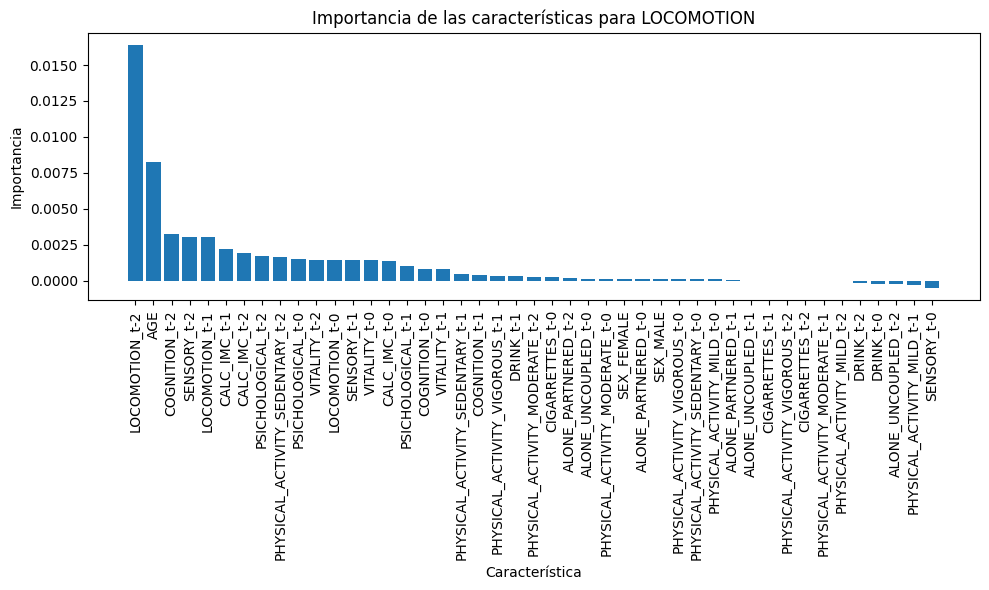

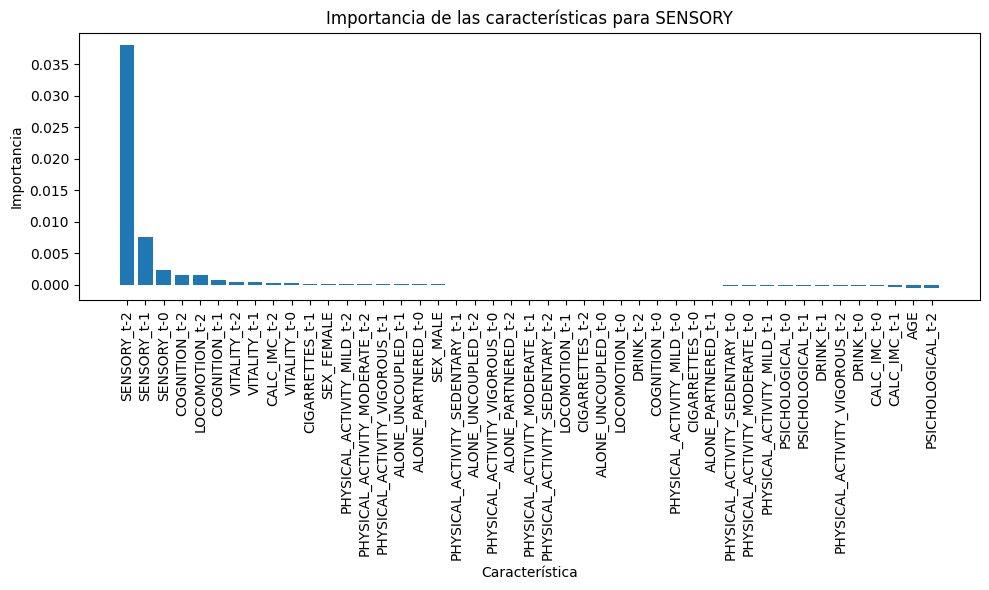

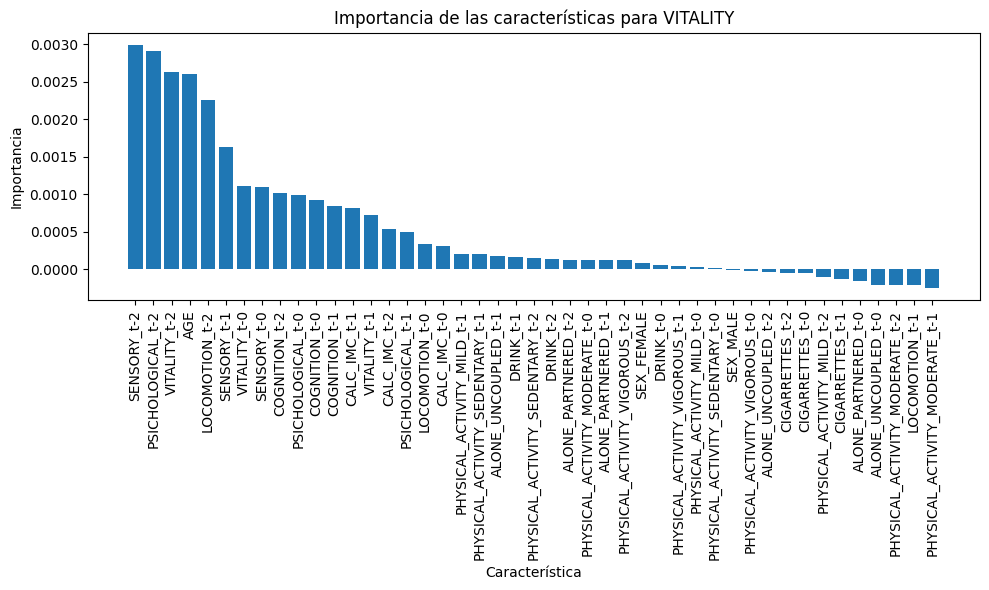

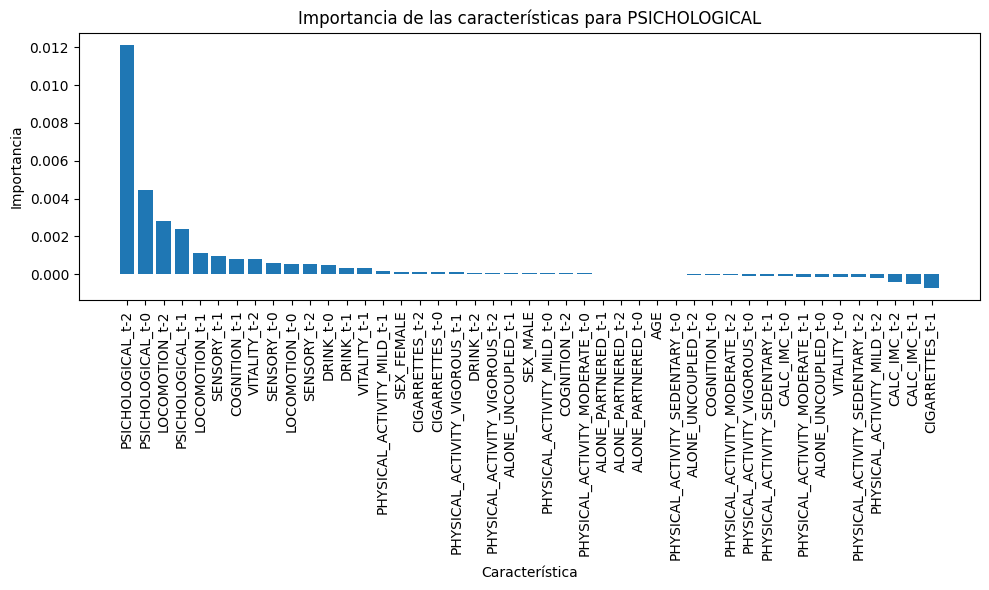

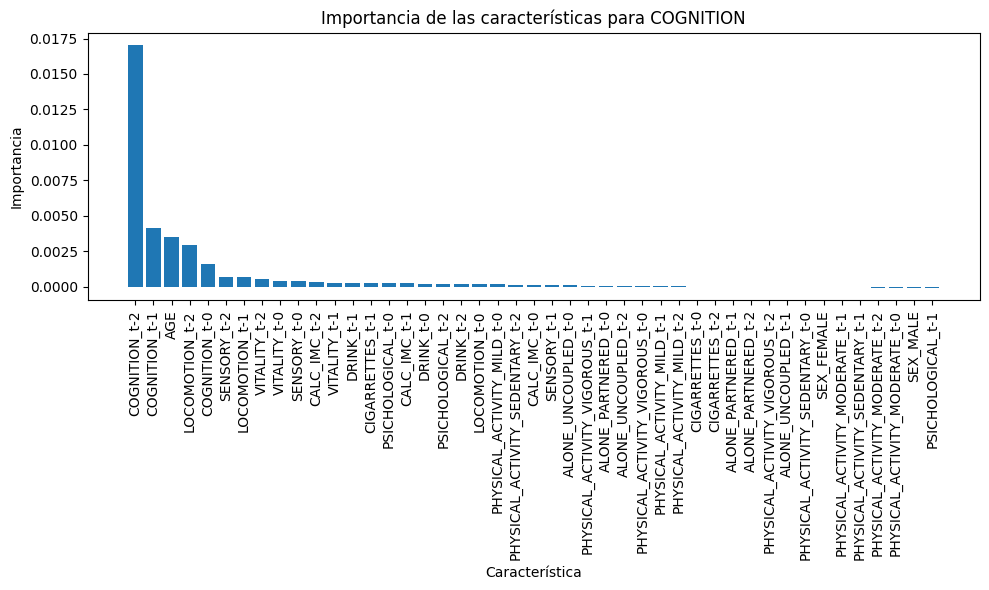

In [ ]:
!pip install scikit-learn
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam # Add this line to import the Adam
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import  make_scorer, mean_absolute_error # Import the mean_absolute_error function
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


%load_ext tensorboard

import os
log_dir = os.path.join("logs") # Puedes cambiar "logs" por el nombre que quieras
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Cargar los datos (suponiendo que están en un archivo CSV)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM.csv')

#ARREGLO PARA CALC_IMC NULL
data['CALC_IMC'] = data.groupby('ID')['CALC_IMC'].transform(lambda x: round(x.fillna(x.mean()), 0))
#eliminar filas con datos nulos en IMC
data = data.dropna(subset=['CALC_IMC'])

# Contar registros por ID, ignorando los NaN
#conteo_registros_por_persona = data.groupby('ID')['ID'].count()

# Personas con exactamente 4 registros (sin considerar NaN)
#personas_con_4_registros = conteo_registros_por_persona[conteo_registros_por_persona == 4]
#print(personas_con_4_registros)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv')

# Normalize numerical variables
columns_to_scale = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION','CIGARRETTES','DRINK','CALC_IMC', 'AGE']
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
#data[columns_to_scale] = scaled_data
data.loc[:, columns_to_scale] = scaled_data

# Convert categorical variables to one-hot encoding
# Crear un objeto OneHotEncoder
columns_to_transform = ['SEX','ALONE','PHYSICAL_ACTIVITY']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[columns_to_transform])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_transform))
data = pd.concat([data, encoded_df], axis=1)

#data = data.drop(columns=['SEX','ALONE','PHYSICAL_ACTIVITY'])

# Agrupar por ID y ordenar por 'Evaluación'
#data_grouped = data.sort_values('evaluacion').groupby('ID')

#data = data.drop(columns=['ID','año','evaluación'])

#data.head()
#print(data.columns)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_ENCODED.csv', index=False)

# Definimos las columnas de las variables a predecir (target)
target_cols = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION']

# Prepare sequences and targets
def create_dataset(data, look_back=3):
  sequences = []
  targets = []
  locomotions = []
  sensories = []
  vitalities = []
  psichologicals = []
  cognitions = []
  auxiliares = []
  for person_id in data['ID'].unique():
    person_data = data[data['ID'] == person_id].sort_values('evaluacion')

     # Get the indices of the relevant columns
    relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY','PSICHOLOGICAL', 'COGNITION',
                        'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                        'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD','PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                        'CIGARRETTES','DRINK', 'CALC_IMC']
    auxiliar_columns = ['AGE','SEX_FEMALE', 'SEX_MALE']
     # Select the relevant columns first
    person_data_values = person_data[relevant_columns].values
    person_data_auxiliar = person_data[auxiliar_columns].values

    # Create sequences and targets
    if len(person_data_values) < look_back + 1:
        continue
    sequence = person_data_values[:look_back, :]
    target = person_data_values[look_back, data.columns.get_indexer(target_cols)]
    locomotion = person_data_values[look_back, 0]
    sensory = person_data_values[look_back, 1]
    vitality = person_data_values[look_back, 2]
    psichological = person_data_values[look_back, 3]
    cognition = person_data_values[look_back, 4]
    auxiliar = person_data_auxiliar[look_back, :]
    sequences.append(sequence)
    targets.append(target)
    locomotions.append(locomotion)
    sensories.append(sensory)
    vitalities.append(vitality)
    psichologicals.append(psichological)
    cognitions.append(cognition)
    auxiliares.append(auxiliar)
  return np.array(sequences), np.array(targets), np.array(locomotions), np.array(sensories), np.array(vitalities), np.array(psichologicals), np.array(cognitions), np.array(auxiliares)

# Create sequences and targets
look_back = 3
sequences, targets, locomotions, sensories, vitalities, psichologicals, cognitions, auxiliares = create_dataset(data, look_back)

pd.DataFrame(sequences[0]).head()
sequences.shape
sequences.shape[2]

sequences.shape[2]
#pd.DataFrame(targets[0]).head()

auxiliares.shape
auxiliares.shape[1]

targets.shape

# TRAINNING AND TEST

# Assuming 'sequences' and 'auxiliares' are your input features,
# and 'locomotions', 'sensories', etc. are your targets
# Split into 80% training and 20% testing
(
    sequences_train,
    sequences_test,
    auxiliares_train,
    auxiliares_test,
    locomotions_train,
    locomotions_test,
    sensories_train,
    sensories_test,
    vitalities_train,
    vitalities_test,
    psichologicals_train,
    psichologicals_test,
    cognitions_train,
    cognitions_test,
) = train_test_split(
    sequences,
    auxiliares,
    locomotions,
    sensories,
    vitalities,
    psichologicals,
    cognitions,
    test_size=0.2,
    random_state=42,  # Optional: for reproducibility
)


# Define input shapes
sequential_input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust num_sequential_features
auxiliary_input_shape = (auxiliares.shape[1],)  # Adjust num_auxiliary_features

# Create the model
def create_model_rf():
    model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
    return model

model = create_model_rf()

# Reshape and combine data for Random Forest
X_train = np.concatenate([sequences_train.reshape(sequences_train.shape[0], -1), auxiliares_train], axis=1)
X_test = np.concatenate([sequences_test.reshape(sequences_test.shape[0], -1), auxiliares_test], axis=1)
y_train = np.concatenate([locomotions_train[:, np.newaxis], sensories_train[:, np.newaxis],
                         vitalities_train[:, np.newaxis], psichologicals_train[:, np.newaxis],
                         cognitions_train[:, np.newaxis]], axis=1)
y_test = np.concatenate([locomotions_test[:, np.newaxis], sensories_test[:, np.newaxis],
                        vitalities_test[:, np.newaxis], psichologicals_test[:, np.newaxis],
                        cognitions_test[:, np.newaxis]], axis=1)

# Train the Random Forest model
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)


# Función para calcular MAE con intervalo de confianza usando Bootstrap (CÓDIGO NUEVO)
def calcular_intervalos_confianza(model, X_test, y_test, num_bootstrap_samples=1000):
    bootstrap_maes = []
    for _ in range(num_bootstrap_samples):
        X_test_resampled, y_test_resampled = resample(X_test, y_test, replace=True)
        predictions = model.predict(X_test_resampled)

     # Calculate MAE for each target and store them
        maes_for_this_bootstrap = [mean_absolute_error(y_test_resampled[:, i], predictions[:, i])
                                 for i in range(y_test.shape[1])]
        bootstrap_maes.append(maes_for_this_bootstrap)

    bootstrap_maes = np.array(bootstrap_maes)
    lower_percentile = 2.5  # For 95% CI
    upper_percentile = 97.5  # For 95% CI

    # Calculate CI directly for MAE values
    confidence_intervals = []
    for i in range(y_test.shape[1]):
        lower_bound = np.percentile(bootstrap_maes[:, i], lower_percentile)
        upper_bound = np.percentile(bootstrap_maes[:, i], upper_percentile)
        confidence_intervals.append((lower_bound, upper_bound))

    return confidence_intervals

confidence_intervals = calcular_intervalos_confianza(model, X_test, y_test)


# Define target names here
target_names = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION']

# --- Evaluation before Confidence Intervals ---
predictions = model.predict(X_test)  # Make predictions on the original test data

# --- Calculate Total Loss ---
total_loss = 0
for i in range(len(target_names)):
    loss_for_target = mean_absolute_error(y_test[:, i], predictions[:, i])
    total_loss += loss_for_target

total_loss /= len(target_names)  # Average the losses

print(f"Total Loss: {total_loss:.4f}")


# Print evaluation metrics (e.g., MAE)
for i in range(len(target_names)):
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    print(f"MAE for {target_names[i]}: {mae:.4f}")



# Calculate confidence intervals
confidence_intervals = calcular_intervalos_confianza(model, X_test, y_test)

# Make predictions using the trained SVM model
predictions = model.predict(X_test)

# Evaluate performance (including confidence intervals)
for i in range(len(target_names)):
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    lower_bound, upper_bound = confidence_intervals[i]
    print(f"MAE for {target_names[i]}: {mae:.4f} (95% CI: [{lower_bound:.4f}, {upper_bound:.4f}])")

# Obtén la importancia de las características
# Get feature names for sequences data
# Get feature names for sequences data
sequence_features = [f'sequence_{i}_{j}' for i in range(sequences_train.shape[1])
                     for j in range(sequences_train.shape[2])]

# --- Mapping to Original Names ---
relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION',
                       'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                       'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD',
                       'PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                       'CIGARRETTES', 'DRINK', 'CALC_IMC']
original_sequence_feature_names = []
for feature_name in sequence_features:
    parts = feature_name.split('_')  # Split the name into parts
    time_step = int(parts[1])  # Get the time step
    feature_index = int(parts[2])  # Get the feature index

    original_name = relevant_columns[feature_index]  # Get the original name from relevant_columns
    original_sequence_feature_names.append(f'{original_name}_t-{time_step}')  # Format the name (e.g., LOCOMOTION_t-0)


# Get feature names for auxiliares data
auxiliary_features = ['AGE', 'SEX_FEMALE', 'SEX_MALE']  # Replace with actual names if different

# Combine feature names
features = original_sequence_feature_names + auxiliary_features


# --- Feature Importance Visualization with Original Names ---
from sklearn.inspection import permutation_importance

target_names = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION']

# Create a wrapper function for single-output prediction
def single_output_model(model, target_index):
    def predict(X):
        return model.predict(X)[:, target_index]  # Return prediction for specific target

    # Add a dummy fit method
    def fit(X, y=None):
        return self

    # Create a class with predict and fit methods
    class SingleOutputModel:
        def __init__(self, predict_func, fit_func):
            self.predict = predict_func
            self.fit = fit_func

    return SingleOutputModel(predict, fit)

for i, target_name in enumerate(target_names):
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Create a single-output model wrapper
    single_output_predictor = single_output_model(model, i)

    result = permutation_importance(
        single_output_predictor,  # Use the wrapper for single output
        X_test,
        y_test[:, i],  # Evaluate for a single target
        n_repeats=10,
        random_state=42,
        scoring=scorer  # Use the custom scorer
    )

    # Organize and plot the results
    importance = result.importances_mean
    features = original_sequence_feature_names + auxiliary_features  # Assuming you have these defined

    # Create a DataFrame for this target's importances
    feature_importances_target = pd.DataFrame({'feature': features, 'importance': importance})
    feature_importances_target = feature_importances_target.sort_values('importance', ascending=False)

    # Plot feature importance for current target
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importances_target['feature'], feature_importances_target['importance'])
    plt.xticks(rotation=90)
    plt.xlabel('Característica')
    plt.ylabel('Importancia')
    plt.title(f'Importancia de las características para {target_name}')
    plt.tight_layout()
    plt.show()

RF CON LIME

In [ ]:
!pip install scikit-learn
!pip install lime
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam # Add this line to import the Adam
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import  make_scorer, mean_absolute_error # Import the mean_absolute_error function
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular


%load_ext tensorboard

import os
log_dir = os.path.join("logs") # Puedes cambiar "logs" por el nombre que quieras
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Cargar los datos (suponiendo que están en un archivo CSV)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM.csv')

#ARREGLO PARA CALC_IMC NULL
data['CALC_IMC'] = data.groupby('ID')['CALC_IMC'].transform(lambda x: round(x.fillna(x.mean()), 0))
#eliminar filas con datos nulos en IMC
data = data.dropna(subset=['CALC_IMC'])

# Contar registros por ID, ignorando los NaN
#conteo_registros_por_persona = data.groupby('ID')['ID'].count()

# Personas con exactamente 4 registros (sin considerar NaN)
#personas_con_4_registros = conteo_registros_por_persona[conteo_registros_por_persona == 4]
#print(personas_con_4_registros)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv')

# Normalize numerical variables
columns_to_scale = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION','CIGARRETTES','DRINK','CALC_IMC', 'AGE']
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
#data[columns_to_scale] = scaled_data
data.loc[:, columns_to_scale] = scaled_data

# Convert categorical variables to one-hot encoding
# Crear un objeto OneHotEncoder
columns_to_transform = ['SEX','ALONE','PHYSICAL_ACTIVITY']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[columns_to_transform])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_transform))
data = pd.concat([data, encoded_df], axis=1)

#data = data.drop(columns=['SEX','ALONE','PHYSICAL_ACTIVITY'])

# Agrupar por ID y ordenar por 'Evaluación'
#data_grouped = data.sort_values('evaluacion').groupby('ID')

#data = data.drop(columns=['ID','año','evaluación'])

#data.head()
#print(data.columns)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_ENCODED.csv', index=False)

# Definimos las columnas de las variables a predecir (target)
target_cols = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION']

# Prepare sequences and targets
def create_dataset(data, look_back=3):
  sequences = []
  targets = []
  locomotions = []
  sensories = []
  vitalities = []
  psichologicals = []
  cognitions = []
  auxiliares = []
  for person_id in data['ID'].unique():
    person_data = data[data['ID'] == person_id].sort_values('evaluacion')

     # Get the indices of the relevant columns
    relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY','PSICHOLOGICAL', 'COGNITION',
                        'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                        'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD','PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                        'CIGARRETTES','DRINK', 'CALC_IMC']
    auxiliar_columns = ['AGE','SEX_FEMALE', 'SEX_MALE']
     # Select the relevant columns first
    person_data_values = person_data[relevant_columns].values
    person_data_auxiliar = person_data[auxiliar_columns].values

    # Create sequences and targets
    if len(person_data_values) < look_back + 1:
        continue
    sequence = person_data_values[:look_back, :]
    target = person_data_values[look_back, data.columns.get_indexer(target_cols)]
    locomotion = person_data_values[look_back, 0]
    sensory = person_data_values[look_back, 1]
    vitality = person_data_values[look_back, 2]
    psichological = person_data_values[look_back, 3]
    cognition = person_data_values[look_back, 4]
    auxiliar = person_data_auxiliar[look_back, :]
    sequences.append(sequence)
    targets.append(target)
    locomotions.append(locomotion)
    sensories.append(sensory)
    vitalities.append(vitality)
    psichologicals.append(psichological)
    cognitions.append(cognition)
    auxiliares.append(auxiliar)
  return np.array(sequences), np.array(targets), np.array(locomotions), np.array(sensories), np.array(vitalities), np.array(psichologicals), np.array(cognitions), np.array(auxiliares)

# Create sequences and targets
look_back = 3
sequences, targets, locomotions, sensories, vitalities, psichologicals, cognitions, auxiliares = create_dataset(data, look_back)

pd.DataFrame(sequences[0]).head()
sequences.shape
sequences.shape[2]

sequences.shape[2]
#pd.DataFrame(targets[0]).head()

auxiliares.shape
auxiliares.shape[1]

targets.shape

# TRAINNING AND TEST

# Assuming 'sequences' and 'auxiliares' are your input features,
# and 'locomotions', 'sensories', etc. are your targets
# Split into 80% training and 20% testing
(
    sequences_train,
    sequences_test,
    auxiliares_train,
    auxiliares_test,
    locomotions_train,
    locomotions_test,
    sensories_train,
    sensories_test,
    vitalities_train,
    vitalities_test,
    psichologicals_train,
    psichologicals_test,
    cognitions_train,
    cognitions_test,
) = train_test_split(
    sequences,
    auxiliares,
    locomotions,
    sensories,
    vitalities,
    psichologicals,
    cognitions,
    test_size=0.2,
    random_state=42,  # Optional: for reproducibility
)


# Define input shapes
sequential_input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust num_sequential_features
auxiliary_input_shape = (auxiliares.shape[1],)  # Adjust num_auxiliary_features

# Create the model
def create_model_rf():
    model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
    return model

model = create_model_rf()

# Reshape and combine data for Random Forest
X_train = np.concatenate([sequences_train.reshape(sequences_train.shape[0], -1), auxiliares_train], axis=1)
X_test = np.concatenate([sequences_test.reshape(sequences_test.shape[0], -1), auxiliares_test], axis=1)
y_train = np.concatenate([locomotions_train[:, np.newaxis], sensories_train[:, np.newaxis],
                         vitalities_train[:, np.newaxis], psichologicals_train[:, np.newaxis],
                         cognitions_train[:, np.newaxis]], axis=1)
y_test = np.concatenate([locomotions_test[:, np.newaxis], sensories_test[:, np.newaxis],
                        vitalities_test[:, np.newaxis], psichologicals_test[:, np.newaxis],
                        cognitions_test[:, np.newaxis]], axis=1)

# Train the Random Forest model
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)


# Función para calcular MAE con intervalo de confianza usando Bootstrap (CÓDIGO NUEVO)
def calcular_intervalos_confianza(model, X_test, y_test, num_bootstrap_samples=1000):
    bootstrap_maes = []
    for _ in range(num_bootstrap_samples):
        X_test_resampled, y_test_resampled = resample(X_test, y_test, replace=True)
        predictions = model.predict(X_test_resampled)

     # Calculate MAE for each target and store them
        maes_for_this_bootstrap = [mean_absolute_error(y_test_resampled[:, i], predictions[:, i])
                                 for i in range(y_test.shape[1])]
        bootstrap_maes.append(maes_for_this_bootstrap)

    bootstrap_maes = np.array(bootstrap_maes)
    lower_percentile = 2.5  # For 95% CI
    upper_percentile = 97.5  # For 95% CI

    # Calculate CI directly for MAE values
    confidence_intervals = []
    for i in range(y_test.shape[1]):
        lower_bound = np.percentile(bootstrap_maes[:, i], lower_percentile)
        upper_bound = np.percentile(bootstrap_maes[:, i], upper_percentile)
        confidence_intervals.append((lower_bound, upper_bound))

    return confidence_intervals

confidence_intervals = calcular_intervalos_confianza(model, X_test, y_test)


# Define target names here
target_names = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION']

# --- Evaluation before Confidence Intervals ---
predictions = model.predict(X_test)  # Make predictions on the original test data

# --- Calculate Total Loss ---
total_loss = 0
for i in range(len(target_names)):
    loss_for_target = mean_absolute_error(y_test[:, i], predictions[:, i])
    total_loss += loss_for_target

total_loss /= len(target_names)  # Average the losses

print(f"Total Loss: {total_loss:.4f}")


# Print evaluation metrics (e.g., MAE)
for i in range(len(target_names)):
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    print(f"MAE for {target_names[i]}: {mae:.4f}")



# Calculate confidence intervals
confidence_intervals = calcular_intervalos_confianza(model, X_test, y_test)

# Make predictions using the trained SVM model
predictions = model.predict(X_test)

# Evaluate performance (including confidence intervals)
for i in range(len(target_names)):
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    lower_bound, upper_bound = confidence_intervals[i]
    print(f"MAE for {target_names[i]}: {mae:.4f} (95% CI: [{lower_bound:.4f}, {upper_bound:.4f}])")

# Obtén la importancia de las características
# Get feature names for sequences data
# Get feature names for sequences data
sequence_features = [f'sequence_{i}_{j}' for i in range(sequences_train.shape[1])
                     for j in range(sequences_train.shape[2])]

# --- Mapping to Original Names ---
relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION',
                       'ALONE_PARTNERED', 'ALONE_UNCOUPLED',
                       'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD',
                       'PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                       'CIGARRETTES', 'DRINK', 'CALC_IMC']
original_sequence_feature_names = []
for feature_name in sequence_features:
    parts = feature_name.split('_')  # Split the name into parts
    time_step = int(parts[1])  # Get the time step
    feature_index = int(parts[2])  # Get the feature index

    original_name = relevant_columns[feature_index]  # Get the original name from relevant_columns
    original_sequence_feature_names.append(f'{original_name}_t-{time_step}')  # Format the name (e.g., LOCOMOTION_t-0)


# Get feature names for auxiliares data
auxiliary_features = ['AGE', 'SEX_FEMALE', 'SEX_MALE']  # Replace with actual names if different

# Combine feature names
features = original_sequence_feature_names + auxiliary_features


# --- Feature Importance Visualization with Original Names ---
from sklearn.inspection import permutation_importance

target_names = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION']

# Create a wrapper function for single-output prediction
def single_output_model(model, target_index):
    def predict(X):
        return model.predict(X)[:, target_index]  # Return prediction for specific target

    # Add a dummy fit method
    def fit(X, y=None):
        return self

    # Create a class with predict and fit methods
    class SingleOutputModel:
        def __init__(self, predict_func, fit_func):
            self.predict = predict_func
            self.fit = fit_func

    return SingleOutputModel(predict, fit)

for i, target_name in enumerate(target_names):
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Create a single-output model wrapper
    single_output_predictor = single_output_model(model, i)

    result = permutation_importance(
        single_output_predictor,  # Use the wrapper for single output
        X_test,
        y_test[:, i],  # Evaluate for a single target
        n_repeats=10,
        random_state=42,
        scoring=scorer  # Use the custom scorer
    )

    # Organize and plot the results
    importance = result.importances_mean
    features = original_sequence_feature_names + auxiliary_features  # Assuming you have these defined

    # Create a DataFrame for this target's importances
    feature_importances_target = pd.DataFrame({'feature': features, 'importance': importance})
    feature_importances_target = feature_importances_target.sort_values('importance', ascending=False)

    # Plot feature importance for current target
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importances_target['feature'], feature_importances_target['importance'])
    plt.xticks(rotation=90)
    plt.xlabel('Característica')
    plt.ylabel('Importancia')
    plt.title(f'Importancia de las características para {target_name}')
    plt.tight_layout()
    plt.show()

#LIME

# Create a wrapper function for single-output prediction (if not already defined)
def single_output_model(model, target_index):
    def predict(X):
        return model.predict(X)[:, target_index]  # Return prediction for specific target

    # Add a dummy fit method (if necessary)
    def fit(X, y=None):
        return self

    # Create a class with predict and fit methods (if necessary)
    class SingleOutputModel:
        def __init__(self, predict_func, fit_func):
            self.predict = predict_func
            self.fit = fit_func

    return SingleOutputModel(predict, fit)

# Define target names (if not already defined)
target_names = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION']

for i, target_name in enumerate(target_names):
    # Create a single-output model wrapper
    single_output_predictor = single_output_model(model, i)

    # Create a LIME explainer for the current target
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train,
        feature_names=features,
        #class_names=[target_name],  # Uncomment if classification task
        mode='regression'
    )

    # Select an instance to explain
    instance_to_explain = X_test[0]  # You can change this to explain other instances

    # Generate explanations for the current target
    explanation = explainer.explain_instance(
        data_row=instance_to_explain,
        predict_fn=single_output_predictor.predict,  # Use the single-output predictor
        num_features=10
    )

    # Display the explanations for the current target
    print(f"LIME Explanation for {target_name}:")
    explanation.show_in_notebook(show_table=True)


Output hidden; open in https://colab.research.google.com to view.

RF SIN AUXILIARY

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<ipython-input-3-f3ffb72e9fc8>:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         0.81818182 0.90909091 ... 0.72727273 0.54545455 0.81818182]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data
<ipython-input-3-f3ffb72e9fc8>:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.61428571 0.65714286 0.71428571 ... 0.32857143 0.38571429 0.44285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, columns_to_scale] = scaled_data


Total Loss: 0.1095
MAE for LOCOMOTION: 0.1505
MAE for SENSORY: 0.0978
MAE for VITALITY: 0.1167
MAE for PSICHOLOGICAL: 0.1005
MAE for COGNITION: 0.0822
MAE for LOCOMOTION: 0.1505 (95% CI: [0.1373, 0.1629])
MAE for SENSORY: 0.0978 (95% CI: [0.0899, 0.1051])
MAE for VITALITY: 0.1167 (95% CI: [0.1093, 0.1250])
MAE for PSICHOLOGICAL: 0.1005 (95% CI: [0.0898, 0.1123])
MAE for COGNITION: 0.0822 (95% CI: [0.0761, 0.0884])


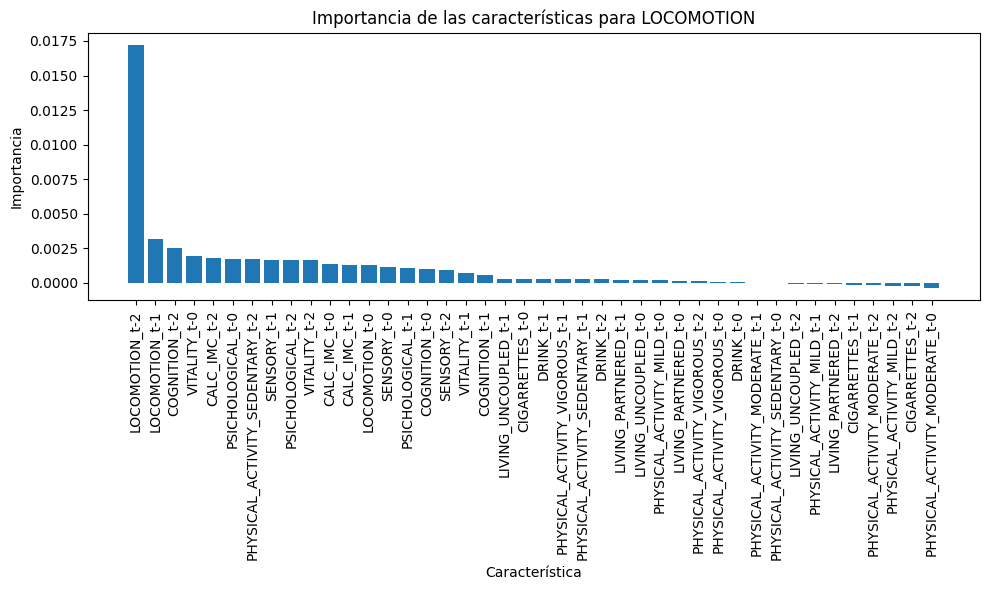

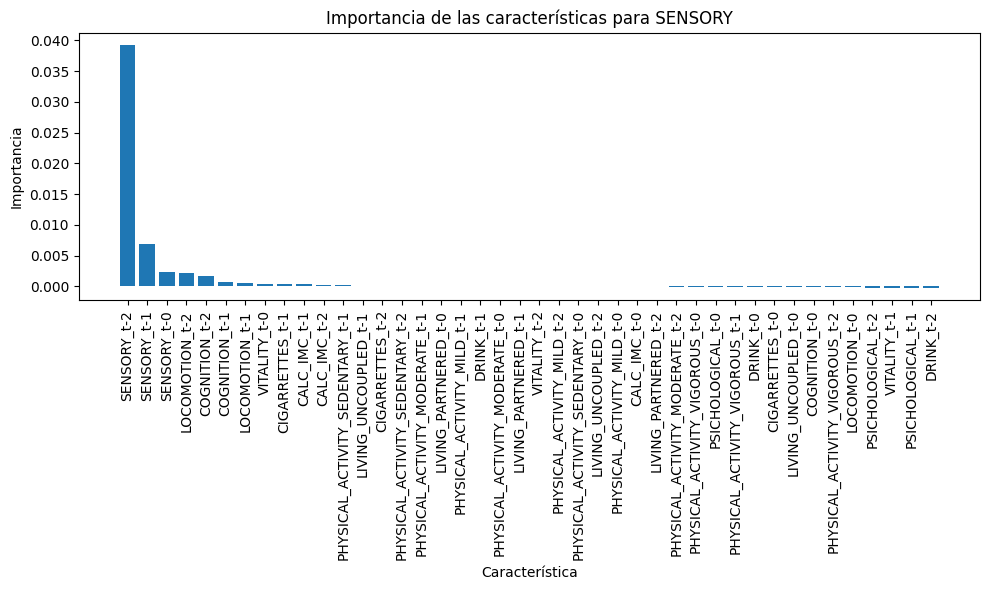

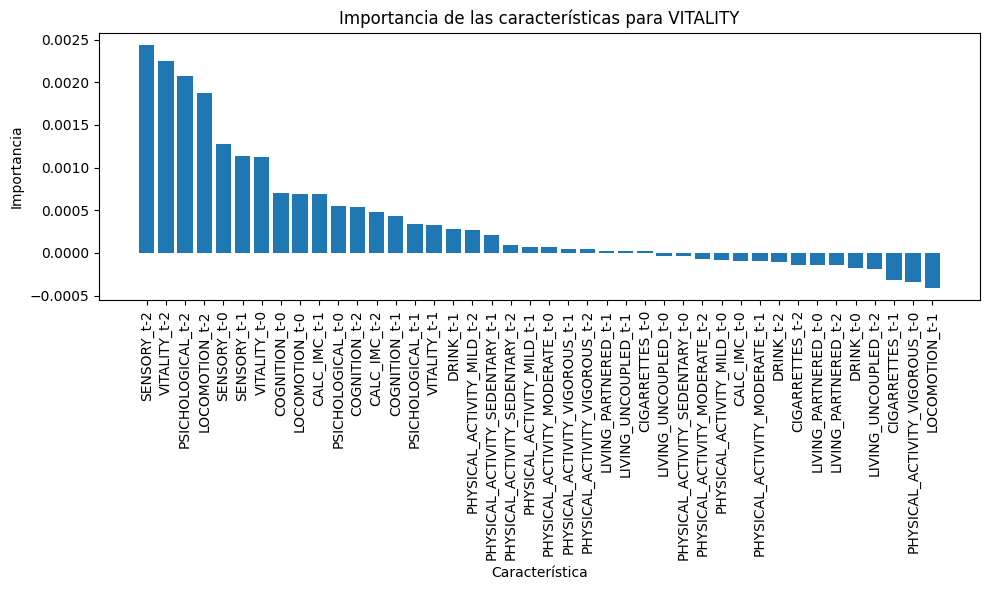

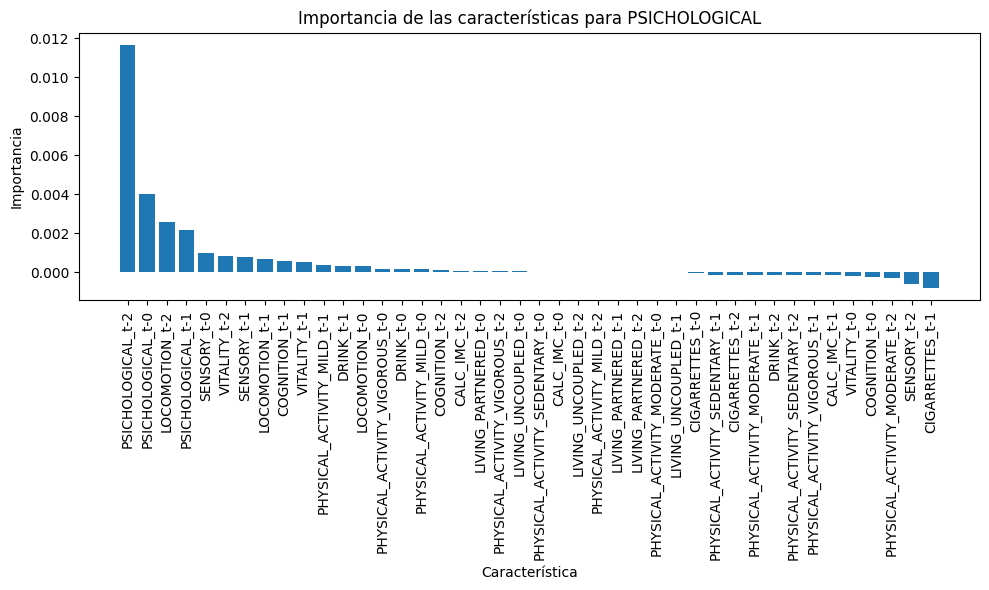

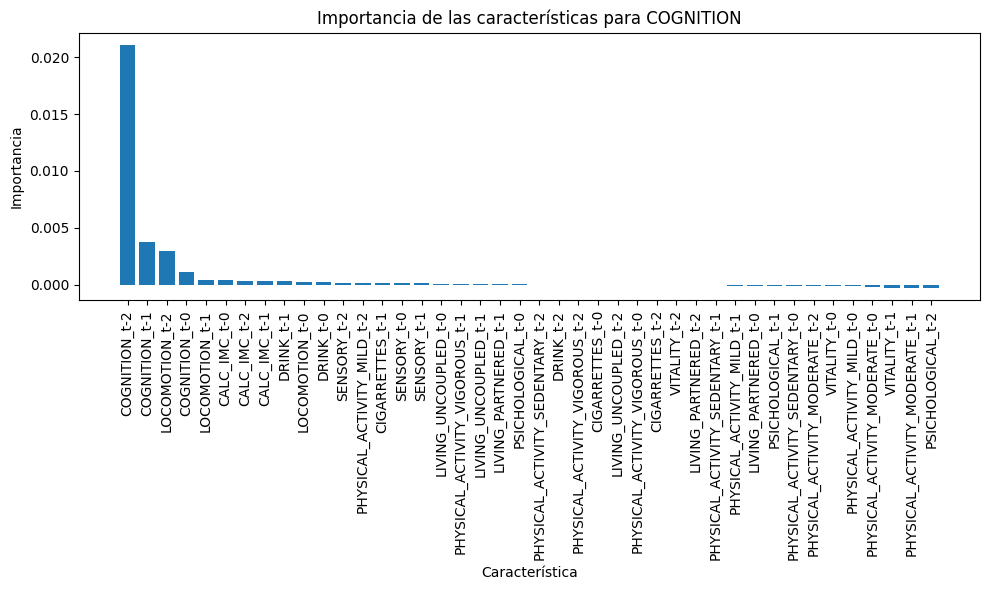

In [3]:
!pip install scikit-learn
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam # Add this line to import the Adam
# Split data into training and test sets
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import  make_scorer, mean_absolute_error # Import the mean_absolute_error function
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


%load_ext tensorboard

import os
log_dir = os.path.join("logs") # Puedes cambiar "logs" por el nombre que quieras
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Cargar los datos (suponiendo que están en un archivo CSV)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM.csv')

#ARREGLO PARA CALC_IMC NULL
data['CALC_IMC'] = data.groupby('ID')['CALC_IMC'].transform(lambda x: round(x.fillna(x.mean()), 0))
#eliminar filas con datos nulos en IMC
data = data.dropna(subset=['CALC_IMC'])

# Contar registros por ID, ignorando los NaN
#conteo_registros_por_persona = data.groupby('ID')['ID'].count()

# Personas con exactamente 4 registros (sin considerar NaN)
#personas_con_4_registros = conteo_registros_por_persona[conteo_registros_por_persona == 4]
#print(personas_con_4_registros)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv', index=False)
data = pd.read_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_1.csv')

# Normalize numerical variables
columns_to_scale = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION','CIGARRETTES','DRINK','CALC_IMC', 'AGE']
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[columns_to_scale])
#data[columns_to_scale] = scaled_data
data.loc[:, columns_to_scale] = scaled_data

# Convert categorical variables to one-hot encoding
# Crear un objeto OneHotEncoder
columns_to_transform = ['SEX','LIVING','PHYSICAL_ACTIVITY']
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(data[columns_to_transform])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(columns_to_transform))
data = pd.concat([data, encoded_df], axis=1)

#data = data.drop(columns=['SEX','ALONE','PHYSICAL_ACTIVITY'])

# Agrupar por ID y ordenar por 'Evaluación'
#data_grouped = data.sort_values('evaluacion').groupby('ID')

#data = data.drop(columns=['ID','año','evaluación'])

#data.head()
#print(data.columns)

data.to_csv('/content/drive/My Drive/PREDICTIVE MODEL IC/DATA/DATOS_OBSERVACION_VAR_NOTNULL2010-2022_TRANSFORM_ENCODED.csv', index=False)

# Definimos las columnas de las variables a predecir (target)
target_cols = ['LOCOMOTION','SENSORY','VITALITY','PSICHOLOGICAL','COGNITION']

# Prepare sequences and targets
def create_dataset(data, look_back=3):
  sequences = []
  targets = []
  locomotions = []
  sensories = []
  vitalities = []
  psichologicals = []
  cognitions = []
  auxiliares = []
  for person_id in data['ID'].unique():
    person_data = data[data['ID'] == person_id].sort_values('evaluacion')

     # Get the indices of the relevant columns
    relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY','PSICHOLOGICAL', 'COGNITION',
                        'LIVING_PARTNERED', 'LIVING_UNCOUPLED',
                        'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD','PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                        'CIGARRETTES','DRINK', 'CALC_IMC']
    auxiliar_columns = ['AGE','SEX_FEMALE', 'SEX_MALE']
     # Select the relevant columns first
    person_data_values = person_data[relevant_columns].values
    person_data_auxiliar = person_data[auxiliar_columns].values

    # Create sequences and targets
    if len(person_data_values) < look_back + 1:
        continue
    sequence = person_data_values[:look_back, :]
    target = person_data_values[look_back, data.columns.get_indexer(target_cols)]
    locomotion = person_data_values[look_back, 0]
    sensory = person_data_values[look_back, 1]
    vitality = person_data_values[look_back, 2]
    psichological = person_data_values[look_back, 3]
    cognition = person_data_values[look_back, 4]
    auxiliar = person_data_auxiliar[look_back, :]
    sequences.append(sequence)
    targets.append(target)
    locomotions.append(locomotion)
    sensories.append(sensory)
    vitalities.append(vitality)
    psichologicals.append(psichological)
    cognitions.append(cognition)
    auxiliares.append(auxiliar)
  return np.array(sequences), np.array(targets), np.array(locomotions), np.array(sensories), np.array(vitalities), np.array(psichologicals), np.array(cognitions), np.array(auxiliares)

# Create sequences and targets
look_back = 3
sequences, targets, locomotions, sensories, vitalities, psichologicals, cognitions, auxiliares = create_dataset(data, look_back)

pd.DataFrame(sequences[0]).head()
sequences.shape
sequences.shape[2]

sequences.shape[2]
#pd.DataFrame(targets[0]).head()

auxiliares.shape
auxiliares.shape[1]

targets.shape

# TRAINNING AND TEST

# Assuming 'sequences' and 'auxiliares' are your input features,
# and 'locomotions', 'sensories', etc. are your targets
# Split into 80% training and 20% testing
(
    sequences_train,
    sequences_test,
    auxiliares_train,
    auxiliares_test,
    locomotions_train,
    locomotions_test,
    sensories_train,
    sensories_test,
    vitalities_train,
    vitalities_test,
    psichologicals_train,
    psichologicals_test,
    cognitions_train,
    cognitions_test,
) = train_test_split(
    sequences,
    auxiliares,
    locomotions,
    sensories,
    vitalities,
    psichologicals,
    cognitions,
    test_size=0.2,
    random_state=42,  # Optional: for reproducibility
)


# Define input shapes
sequential_input_shape = (sequences.shape[1], sequences.shape[2])  # Adjust num_sequential_features
auxiliary_input_shape = (auxiliares.shape[1],)  # Adjust num_auxiliary_features

# Create the model
def create_model_rf():
    model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters
    return model

model = create_model_rf()

# Reshape and combine data for Random Forest
X_train = np.concatenate([sequences_train.reshape(sequences_train.shape[0], -1)], axis=1)
X_test = np.concatenate([sequences_test.reshape(sequences_test.shape[0], -1)], axis=1)
y_train = np.concatenate([locomotions_train[:, np.newaxis], sensories_train[:, np.newaxis],
                         vitalities_train[:, np.newaxis], psichologicals_train[:, np.newaxis],
                         cognitions_train[:, np.newaxis]], axis=1)
y_test = np.concatenate([locomotions_test[:, np.newaxis], sensories_test[:, np.newaxis],
                        vitalities_test[:, np.newaxis], psichologicals_test[:, np.newaxis],
                        cognitions_test[:, np.newaxis]], axis=1)

# Train the Random Forest model
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)


# Función para calcular MAE con intervalo de confianza usando Bootstrap (CÓDIGO NUEVO)
def calcular_intervalos_confianza(model, X_test, y_test, num_bootstrap_samples=1000):
    bootstrap_maes = []
    for _ in range(num_bootstrap_samples):
        X_test_resampled, y_test_resampled = resample(X_test, y_test, replace=True)
        predictions = model.predict(X_test_resampled)

     # Calculate MAE for each target and store them
        maes_for_this_bootstrap = [mean_absolute_error(y_test_resampled[:, i], predictions[:, i])
                                 for i in range(y_test.shape[1])]
        bootstrap_maes.append(maes_for_this_bootstrap)

    bootstrap_maes = np.array(bootstrap_maes)
    lower_percentile = 2.5  # For 95% CI
    upper_percentile = 97.5  # For 95% CI

    # Calculate CI directly for MAE values
    confidence_intervals = []
    for i in range(y_test.shape[1]):
        lower_bound = np.percentile(bootstrap_maes[:, i], lower_percentile)
        upper_bound = np.percentile(bootstrap_maes[:, i], upper_percentile)
        confidence_intervals.append((lower_bound, upper_bound))

    return confidence_intervals

confidence_intervals = calcular_intervalos_confianza(model, X_test, y_test)


# Define target names here
target_names = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION']

# --- Evaluation before Confidence Intervals ---
predictions = model.predict(X_test)  # Make predictions on the original test data

# --- Calculate Total Loss ---
total_loss = 0
for i in range(len(target_names)):
    loss_for_target = mean_absolute_error(y_test[:, i], predictions[:, i])
    total_loss += loss_for_target

total_loss /= len(target_names)  # Average the losses

print(f"Total Loss: {total_loss:.4f}")


# Print evaluation metrics (e.g., MAE)
for i in range(len(target_names)):
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    print(f"MAE for {target_names[i]}: {mae:.4f}")



# Calculate confidence intervals
confidence_intervals = calcular_intervalos_confianza(model, X_test, y_test)

# Make predictions using the trained SVM model
predictions = model.predict(X_test)

# Evaluate performance (including confidence intervals)
for i in range(len(target_names)):
    mae = mean_absolute_error(y_test[:, i], predictions[:, i])
    lower_bound, upper_bound = confidence_intervals[i]
    print(f"MAE for {target_names[i]}: {mae:.4f} (95% CI: [{lower_bound:.4f}, {upper_bound:.4f}])")

# Obtén la importancia de las características
# Get feature names for sequences data
# Get feature names for sequences data
sequence_features = [f'sequence_{i}_{j}' for i in range(sequences_train.shape[1])
                     for j in range(sequences_train.shape[2])]

# --- Mapping to Original Names ---
relevant_columns = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION',
                       'LIVING_PARTNERED', 'LIVING_UNCOUPLED',
                       'PHYSICAL_ACTIVITY_SEDENTARY', 'PHYSICAL_ACTIVITY_MILD',
                       'PHYSICAL_ACTIVITY_MODERATE', 'PHYSICAL_ACTIVITY_VIGOROUS',
                       'CIGARRETTES', 'DRINK', 'CALC_IMC']
original_sequence_feature_names = []
for feature_name in sequence_features:
    parts = feature_name.split('_')  # Split the name into parts
    time_step = int(parts[1])  # Get the time step
    feature_index = int(parts[2])  # Get the feature index

    original_name = relevant_columns[feature_index]  # Get the original name from relevant_columns
    original_sequence_feature_names.append(f'{original_name}_t-{time_step}')  # Format the name (e.g., LOCOMOTION_t-0)


# Get feature names for auxiliares data
auxiliary_features = ['AGE', 'SEX_FEMALE', 'SEX_MALE']  # Replace with actual names if different

# Combine feature names
features = original_sequence_feature_names


# --- Feature Importance Visualization with Original Names ---
from sklearn.inspection import permutation_importance

target_names = ['LOCOMOTION', 'SENSORY', 'VITALITY', 'PSICHOLOGICAL', 'COGNITION']

# Create a wrapper function for single-output prediction
def single_output_model(model, target_index):
    def predict(X):
        return model.predict(X)[:, target_index]  # Return prediction for specific target

    # Add a dummy fit method
    def fit(X, y=None):
        return self

    # Create a class with predict and fit methods
    class SingleOutputModel:
        def __init__(self, predict_func, fit_func):
            self.predict = predict_func
            self.fit = fit_func

    return SingleOutputModel(predict, fit)

for i, target_name in enumerate(target_names):
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Create a single-output model wrapper
    single_output_predictor = single_output_model(model, i)

    result = permutation_importance(
        single_output_predictor,  # Use the wrapper for single output
        X_test,
        y_test[:, i],  # Evaluate for a single target
        n_repeats=10,
        random_state=42,
        scoring=scorer  # Use the custom scorer
    )

    # Organize and plot the results
    importance = result.importances_mean
    features = original_sequence_feature_names # Assuming you have these defined

    # Create a DataFrame for this target's importances
    feature_importances_target = pd.DataFrame({'feature': features, 'importance': importance})
    feature_importances_target = feature_importances_target.sort_values('importance', ascending=False)

    # Plot feature importance for current target
    plt.figure(figsize=(10, 6))
    plt.bar(feature_importances_target['feature'], feature_importances_target['importance'])
    plt.xticks(rotation=90)
    plt.xlabel('Característica')
    plt.ylabel('Importancia')
    plt.title(f'Importancia de las características para {target_name}')
    plt.tight_layout()
    plt.show()